# Load data

In [1]:
import pandas as pd
from constants import NULLABLE_MEASURES
from utils.class_patient import Patients

patients = Patients.loadPatients()
patients.fillMissingMeasureValue(NULLABLE_MEASURES, 0)

# Remove missing data

## Remove features with more than 20% missing

In [2]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


## Remove patients with more than 20% missing features

In [3]:
patients.removePatientByMissingFeatures()
len(patients)

1206

## Display insight

In [4]:
# dfData = patients.getMeasuresBetween(pd.Timedelta(hours=-6), pd.Timedelta(hours=24), "first")

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(patients.getMeasures())

Counter({'age': 1206,
         'chronic_pulmonary_disease': 1206,
         'ckd_stage': 1206,
         'congestive_heart_failure': 1206,
         'dka_type': 1206,
         'gender': 1206,
         'history_aci': 1206,
         'history_ami': 1206,
         'hypertension': 1206,
         'liver_disease': 1206,
         'macroangiopathy': 1206,
         'malignant_cancer': 1206,
         'mechanical_ventilation': 1206,
         'microangiopathy': 1206,
         'oasis': 1206,
         'preiculos': 1206,
         'race': 1206,
         'saps2': 1206,
         'sofa': 1206,
         'use_NaHCO3': 1206,
         'uti': 1206,
         'ag': 1205,
         'bg': 1205,
         'bicarbonate': 1205,
         'bun': 1205,
         'chloride': 1205,
         'egfr': 1205,
         'hr': 1205,
         'potassium': 1205,
         'scr': 1205,
         'sodium': 1205,
         'dbp': 1204,
         'gcs': 1204,
         'gcs_unable': 1204,
         'rr': 1204,
         'sbp': 1204,
         'calci

In [5]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.39303482587064675

# Machine learning

In [6]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

## Split train-test

In [7]:
splitedPatients = patients.split(5, 27)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

## Define model

In [8]:
import xgboost as xgb

how = "first"

params = {
    "validate_parameters": True,
    "device": "gpu",  # Use GPU acceleration
    "n_jobs": -1,  # Use all CPU cores
    "eval_metric": "logloss",  # Evaluation metric
    "max_depth": 6,  # Maximum depth of a tree
    "min_child_weight": 1,  # Minimum sum of instance weight (hessian) needed in a child
    "gamma": 0,  # Minimum loss reduction required to make a further partition on a leaf node
    "subsample": 0.8,  # Subsample ratio of the training instances
    "colsample_bytree": 0.8,  # Subsample ratio of columns when constructing each tree
    "reg_alpha": 0.01,  # L1 regularization term on weights
    "reg_lambda": 1,  # L2 regularization term on weights
    "objective": "binary:logistic",  # Binary classification objective
    "n_estimators": 1000,  # Number of trees
    "learning_rate": 0.01,  # Learning rate
    "early_stopping_rounds": 10,  # Early stopping
    "verbose": 0,  # Verbosity
}


def createModel():
    model = xgb.XGBClassifier(**params)
    return model

`functionize-notebook` has modified this notebook during execution. The following variables have been injected:

- how: first


## Without validate

### Without fill missing data

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from utils.prepare_data import normalizeData


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))

/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:54:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:54:07] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:54:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:54:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:55:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:55:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:

print(f"Average AUC: {np.mean(auc_score_list)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list)}")
print(f"Average Precision: {np.mean(precision_score_list)}")
print(f"Average Recall: {np.mean(recall_score_list)}")

Average AUC: 0.8127928849061906
Average Accuracy: 0.754548883783135
Average Precision: 0.7132678354954857
Average Recall: 0.6328779395296753


### Fill missing with knn

In [12]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_knn = []
precision_score_list_knn = []
recall_score_list_knn = []
auc_score_list_knn = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeAndFillData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_knn.append(precision_score(y_test, y_pred))
    recall_score_list_knn.append(recall_score(y_test, y_pred))
    auc_score_list_knn.append(roc_auc_score(y_test, y_pred_proba))

/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:55:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:56:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:56:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:56:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:57:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [13]:

print(f"Average AUC: {np.mean(auc_score_list_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_knn)}")

Average AUC: 0.7957721926918306
Average Accuracy: 0.7263811254758068
Average Precision: 0.6718624485029204
Average Recall: 0.5929003359462486


## With validate

### Without fill missing data

In [14]:
from utils.prepare_data import normalizeData


accuracy_score_list_val = []
precision_score_list_val = []
recall_score_list_val = []
auc_score_list_val = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn]) # type: ignore
    y_val = dfVal[labelColumn] # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val.append(accuracy_score(y_test, y_pred))
    precision_score_list_val.append(precision_score(y_test, y_pred))
    recall_score_list_val.append(recall_score(y_test, y_pred))
    auc_score_list_val.append(roc_auc_score(y_test, y_pred_proba))

[0]	validation_0-logloss:0.66595


[1]	validation_0-logloss:0.66299


[2]	validation_0-logloss:0.65986


[3]	validation_0-logloss:0.65711


[4]	validation_0-logloss:0.65451


[5]	validation_0-logloss:0.65203


[6]	validation_0-logloss:0.64947


[7]	validation_0-logloss:0.64731


[8]	validation_0-logloss:0.64431


[9]	validation_0-logloss:0.64220


[10]	validation_0-logloss:0.63959


[11]	validation_0-logloss:0.63755


[12]	validation_0-logloss:0.63500


[13]	validation_0-logloss:0.63266


[14]	validation_0-logloss:0.63115


[15]	validation_0-logloss:0.62919


[16]	validation_0-logloss:0.62671


[17]	validation_0-logloss:0.62449


[18]	validation_0-logloss:0.62240


[19]	validation_0-logloss:0.62038


[20]	validation_0-logloss:0.61808


[21]	validation_0-logloss:0.61671


[22]	validation_0-logloss:0.61467


[23]	validation_0-logloss:0.61274


[24]	validation_0-logloss:0.61081


[25]	validation_0-logloss:0.60942


[26]	validation_0-logloss:0.60783


[27]	validation_0-logloss:0.60626


[28]	validation_0-logloss:0.60465


[29]	validation_0-logloss:0.60274


[30]	validation_0-logloss:0.60109


[31]	validation_0-logloss:0.59942


[32]	validation_0-logloss:0.59775


[33]	validation_0-logloss:0.59610


[34]	validation_0-logloss:0.59447


[35]	validation_0-logloss:0.59302


[36]	validation_0-logloss:0.59174


[37]	validation_0-logloss:0.59022


[38]	validation_0-logloss:0.58876


[39]	validation_0-logloss:0.58725


[40]	validation_0-logloss:0.58607


[41]	validation_0-logloss:0.58457


[42]	validation_0-logloss:0.58338


[43]	validation_0-logloss:0.58199


[44]	validation_0-logloss:0.58063


[45]	validation_0-logloss:0.57973


[46]	validation_0-logloss:0.57847


[47]	validation_0-logloss:0.57730


[48]	validation_0-logloss:0.57611


[49]	validation_0-logloss:0.57486


[50]	validation_0-logloss:0.57336


[51]	validation_0-logloss:0.57218


[52]	validation_0-logloss:0.57117


[53]	validation_0-logloss:0.56983


[54]	validation_0-logloss:0.56857


[55]	validation_0-logloss:0.56715


[56]	validation_0-logloss:0.56633


[57]	validation_0-logloss:0.56529


[58]	validation_0-logloss:0.56456


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:57:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[59]	validation_0-logloss:0.56357


[60]	validation_0-logloss:0.56248


[61]	validation_0-logloss:0.56112


[62]	validation_0-logloss:0.56006


[63]	validation_0-logloss:0.55882


[64]	validation_0-logloss:0.55759


[65]	validation_0-logloss:0.55675


[66]	validation_0-logloss:0.55553


[67]	validation_0-logloss:0.55508


[68]	validation_0-logloss:0.55394


[69]	validation_0-logloss:0.55349


[70]	validation_0-logloss:0.55284


[71]	validation_0-logloss:0.55181


[72]	validation_0-logloss:0.55120


[73]	validation_0-logloss:0.55013


[74]	validation_0-logloss:0.54934


[75]	validation_0-logloss:0.54885


[76]	validation_0-logloss:0.54846


[77]	validation_0-logloss:0.54780


[78]	validation_0-logloss:0.54716


[79]	validation_0-logloss:0.54644


[80]	validation_0-logloss:0.54513


[81]	validation_0-logloss:0.54457

[82]	validation_0-logloss:0.54331


[83]	validation_0-logloss:0.54302


[84]	validation_0-logloss:0.54153


[85]	validation_0-logloss:0.54059


[86]	validation_0-logloss:0.53980


[87]	validation_0-logloss:0.53925


[88]	validation_0-logloss:0.53872


[89]	validation_0-logloss:0.53789


[90]	validation_0-logloss:0.53676


[91]	validation_0-logloss:0.53630


[92]	validation_0-logloss:0.53572


[93]	validation_0-logloss:0.53498


[94]	validation_0-logloss:0.53411


[95]	validation_0-logloss:0.53290


[96]	validation_0-logloss:0.53219


[97]	validation_0-logloss:0.53182


[98]	validation_0-logloss:0.53135


[99]	validation_0-logloss:0.53070


[100]	validation_0-logloss:0.52995


[101]	validation_0-logloss:0.52890


[102]	validation_0-logloss:0.52846


[103]	validation_0-logloss:0.52775


[104]	validation_0-logloss:0.52739


[105]	validation_0-logloss:0.52661


[106]	validation_0-logloss:0.52589


[107]	validation_0-logloss:0.52528


[108]	validation_0-logloss:0.52463


[109]	validation_0-logloss:0.52390


[110]	validation_0-logloss:0.52366


[111]	validation_0-logloss:0.52315


[112]	validation_0-logloss:0.52246


[113]	validation_0-logloss:0.52157


[114]	validation_0-logloss:0.52060


[115]	validation_0-logloss:0.52042


[116]	validation_0-logloss:0.51976


[117]	validation_0-logloss:0.51901


[118]	validation_0-logloss:0.51866


[119]	validation_0-logloss:0.51816


[120]	validation_0-logloss:0.51766


[121]	validation_0-logloss:0.51707


[122]	validation_0-logloss:0.51685


[123]	validation_0-logloss:0.51654


[124]	validation_0-logloss:0.51610


[125]	validation_0-logloss:0.51566


[126]	validation_0-logloss:0.51570


[127]	validation_0-logloss:0.51509


[128]	validation_0-logloss:0.51465


[129]	validation_0-logloss:0.51419


[130]	validation_0-logloss:0.51331


[131]	validation_0-logloss:0.51307


[132]	validation_0-logloss:0.51256


[133]	validation_0-logloss:0.51210


[134]	validation_0-logloss:0.51177


[135]	validation_0-logloss:0.51108


[136]	validation_0-logloss:0.51094


[137]	validation_0-logloss:0.51020


[138]	validation_0-logloss:0.50970


[139]	validation_0-logloss:0.50977


[140]	validation_0-logloss:0.50953


[141]	validation_0-logloss:0.50942


[142]	validation_0-logloss:0.50906


[143]	validation_0-logloss:0.50834

[144]	validation_0-logloss:0.50778

[145]	validation_0-logloss:0.50710


[146]	validation_0-logloss:0.50673


[147]	validation_0-logloss:0.50597


[148]	validation_0-logloss:0.50571


[149]	validation_0-logloss:0.50571


[150]	validation_0-logloss:0.50558


[151]	validation_0-logloss:0.50499


[152]	validation_0-logloss:0.50454


[153]	validation_0-logloss:0.50456


[154]	validation_0-logloss:0.50431


[155]	validation_0-logloss:0.50415


[156]	validation_0-logloss:0.50394


[157]	validation_0-logloss:0.50365


[158]	validation_0-logloss:0.50320


[159]	validation_0-logloss:0.50266


[160]	validation_0-logloss:0.50232


[161]	validation_0-logloss:0.50223


[162]	validation_0-logloss:0.50196


[163]	validation_0-logloss:0.50191


[164]	validation_0-logloss:0.50166


[165]	validation_0-logloss:0.50169


[166]	validation_0-logloss:0.50158


[167]	validation_0-logloss:0.50134


[168]	validation_0-logloss:0.50150


[169]	validation_0-logloss:0.50125


[170]	validation_0-logloss:0.50065


[171]	validation_0-logloss:0.50084


[172]	validation_0-logloss:0.50034


[173]	validation_0-logloss:0.50034


[174]	validation_0-logloss:0.49986


[175]	validation_0-logloss:0.49957


[176]	validation_0-logloss:0.49928


[177]	validation_0-logloss:0.49889


[178]	validation_0-logloss:0.49905


[179]	validation_0-logloss:0.49901


[180]	validation_0-logloss:0.49888


[181]	validation_0-logloss:0.49865


[182]	validation_0-logloss:0.49807


[183]	validation_0-logloss:0.49805


[184]	validation_0-logloss:0.49775


[185]	validation_0-logloss:0.49732


[186]	validation_0-logloss:0.49704


[187]	validation_0-logloss:0.49694


[188]	validation_0-logloss:0.49693


[189]	validation_0-logloss:0.49657


[190]	validation_0-logloss:0.49609


[191]	validation_0-logloss:0.49605


[192]	validation_0-logloss:0.49610


[193]	validation_0-logloss:0.49602


[194]	validation_0-logloss:0.49600


[195]	validation_0-logloss:0.49556


[196]	validation_0-logloss:0.49546


[197]	validation_0-logloss:0.49523


[198]	validation_0-logloss:0.49534


[199]	validation_0-logloss:0.49497


[200]	validation_0-logloss:0.49477


[201]	validation_0-logloss:0.49466


[202]	validation_0-logloss:0.49437


[203]	validation_0-logloss:0.49400


[204]	validation_0-logloss:0.49402


[205]	validation_0-logloss:0.49406


[206]	validation_0-logloss:0.49405


[207]	validation_0-logloss:0.49354


[208]	validation_0-logloss:0.49344


[209]	validation_0-logloss:0.49358


[210]	validation_0-logloss:0.49355


[211]	validation_0-logloss:0.49364


[212]	validation_0-logloss:0.49359


[213]	validation_0-logloss:0.49332


[214]	validation_0-logloss:0.49344


[215]	validation_0-logloss:0.49339


[216]	validation_0-logloss:0.49317


[217]	validation_0-logloss:0.49293


[218]	validation_0-logloss:0.49267


[219]	validation_0-logloss:0.49226


[220]	validation_0-logloss:0.49209


[221]	validation_0-logloss:0.49226


[222]	validation_0-logloss:0.49202


[223]	validation_0-logloss:0.49168


[224]	validation_0-logloss:0.49164


[225]	validation_0-logloss:0.49137


[226]	validation_0-logloss:0.49135


[227]	validation_0-logloss:0.49129


[228]	validation_0-logloss:0.49145


[229]	validation_0-logloss:0.49145

[230]	validation_0-logloss:0.49111


[231]	validation_0-logloss:0.49104


[232]	validation_0-logloss:0.49106


[233]	validation_0-logloss:0.49102


[234]	validation_0-logloss:0.49098


[235]	validation_0-logloss:0.49069


[236]	validation_0-logloss:0.49099


[237]	validation_0-logloss:0.49088


[238]	validation_0-logloss:0.49096


[239]	validation_0-logloss:0.49087


[240]	validation_0-logloss:0.49081


[241]	validation_0-logloss:0.49043


[242]	validation_0-logloss:0.49006


[243]	validation_0-logloss:0.49003


[244]	validation_0-logloss:0.49003


[245]	validation_0-logloss:0.48998


[246]	validation_0-logloss:0.49009


[247]	validation_0-logloss:0.48971

[248]	validation_0-logloss:0.48961


[249]	validation_0-logloss:0.48928


[250]	validation_0-logloss:0.48930


[251]	validation_0-logloss:0.48924

[252]	validation_0-logloss:0.48927


[253]	validation_0-logloss:0.48924


[254]	validation_0-logloss:0.48902


[255]	validation_0-logloss:0.48900


[256]	validation_0-logloss:0.48870


[257]	validation_0-logloss:0.48860


[258]	validation_0-logloss:0.48861


[259]	validation_0-logloss:0.48821


[260]	validation_0-logloss:0.48830


[261]	validation_0-logloss:0.48829


[262]	validation_0-logloss:0.48810


[263]	validation_0-logloss:0.48792


[264]	validation_0-logloss:0.48773


[265]	validation_0-logloss:0.48773


[266]	validation_0-logloss:0.48767


[267]	validation_0-logloss:0.48788


[268]	validation_0-logloss:0.48771


[269]	validation_0-logloss:0.48751


[270]	validation_0-logloss:0.48746


[271]	validation_0-logloss:0.48755

[272]	validation_0-logloss:0.48766


[273]	validation_0-logloss:0.48759


[274]	validation_0-logloss:0.48710


[275]	validation_0-logloss:0.48691

[276]	validation_0-logloss:0.48674


[277]	validation_0-logloss:0.48656


[278]	validation_0-logloss:0.48646


[279]	validation_0-logloss:0.48642


[280]	validation_0-logloss:0.48605


[281]	validation_0-logloss:0.48617


[282]	validation_0-logloss:0.48594


[283]	validation_0-logloss:0.48586


[284]	validation_0-logloss:0.48587


[285]	validation_0-logloss:0.48553


[286]	validation_0-logloss:0.48500


[287]	validation_0-logloss:0.48491


[288]	validation_0-logloss:0.48508


[289]	validation_0-logloss:0.48512


[290]	validation_0-logloss:0.48539


[291]	validation_0-logloss:0.48520


[292]	validation_0-logloss:0.48518


[293]	validation_0-logloss:0.48520


[294]	validation_0-logloss:0.48523


[295]	validation_0-logloss:0.48551


[296]	validation_0-logloss:0.48551

[297]	validation_0-logloss:0.48529


[0]	validation_0-logloss:0.66795


[1]	validation_0-logloss:0.66552


[2]	validation_0-logloss:0.66296


[3]	validation_0-logloss:0.66065


[4]	validation_0-logloss:0.65817


[5]	validation_0-logloss:0.65588


[6]	validation_0-logloss:0.65316


[7]	validation_0-logloss:0.65071


[8]	validation_0-logloss:0.64870


[9]	validation_0-logloss:0.64645


[10]	validation_0-logloss:0.64417


[11]	validation_0-logloss:0.64231


[12]	validation_0-logloss:0.64043


[13]	validation_0-logloss:0.63880


[14]	validation_0-logloss:0.63680


[15]	validation_0-logloss:0.63502


[16]	validation_0-logloss:0.63421


[17]	validation_0-logloss:0.63269


[18]	validation_0-logloss:0.63112


[19]	validation_0-logloss:0.62916


[20]	validation_0-logloss:0.62754


[21]	validation_0-logloss:0.62549


[22]	validation_0-logloss:0.62347


[23]	validation_0-logloss:0.62178


[24]	validation_0-logloss:0.61985


[25]	validation_0-logloss:0.61797


[26]	validation_0-logloss:0.61676


[27]	validation_0-logloss:0.61534


[28]	validation_0-logloss:0.61384


[29]	validation_0-logloss:0.61186


[30]	validation_0-logloss:0.60987


[31]	validation_0-logloss:0.60836


[32]	validation_0-logloss:0.60669


[33]	validation_0-logloss:0.60574


[34]	validation_0-logloss:0.60436


[35]	validation_0-logloss:0.60294


[36]	validation_0-logloss:0.60154


[37]	validation_0-logloss:0.60029


[38]	validation_0-logloss:0.59870


[39]	validation_0-logloss:0.59703


[40]	validation_0-logloss:0.59625


[41]	validation_0-logloss:0.59469


[42]	validation_0-logloss:0.59369


[43]	validation_0-logloss:0.59306


[44]	validation_0-logloss:0.59158


[45]	validation_0-logloss:0.59043


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:57:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[46]	validation_0-logloss:0.58917


[47]	validation_0-logloss:0.58816


[48]	validation_0-logloss:0.58718


[49]	validation_0-logloss:0.58621


[50]	validation_0-logloss:0.58512

[51]	validation_0-logloss:0.58353


[52]	validation_0-logloss:0.58272


[53]	validation_0-logloss:0.58175


[54]	validation_0-logloss:0.58027


[55]	validation_0-logloss:0.57944


[56]	validation_0-logloss:0.57819


[57]	validation_0-logloss:0.57706


[58]	validation_0-logloss:0.57580


[59]	validation_0-logloss:0.57439


[60]	validation_0-logloss:0.57351


[61]	validation_0-logloss:0.57242


[62]	validation_0-logloss:0.57131


[63]	validation_0-logloss:0.57022


[64]	validation_0-logloss:0.56956


[65]	validation_0-logloss:0.56905


[66]	validation_0-logloss:0.56795


[67]	validation_0-logloss:0.56724


[68]	validation_0-logloss:0.56636


[69]	validation_0-logloss:0.56551


[70]	validation_0-logloss:0.56492


[71]	validation_0-logloss:0.56411


[72]	validation_0-logloss:0.56376


[73]	validation_0-logloss:0.56292


[74]	validation_0-logloss:0.56202


[75]	validation_0-logloss:0.56111


[76]	validation_0-logloss:0.56048


[77]	validation_0-logloss:0.55994


[78]	validation_0-logloss:0.55892


[79]	validation_0-logloss:0.55856


[80]	validation_0-logloss:0.55806


[81]	validation_0-logloss:0.55749


[82]	validation_0-logloss:0.55684


[83]	validation_0-logloss:0.55600


[84]	validation_0-logloss:0.55523


[85]	validation_0-logloss:0.55468


[86]	validation_0-logloss:0.55442


[87]	validation_0-logloss:0.55389


[88]	validation_0-logloss:0.55322


[89]	validation_0-logloss:0.55266


[90]	validation_0-logloss:0.55206


[91]	validation_0-logloss:0.55120


[92]	validation_0-logloss:0.55060


[93]	validation_0-logloss:0.54949


[94]	validation_0-logloss:0.54873


[95]	validation_0-logloss:0.54820


[96]	validation_0-logloss:0.54771

[97]	validation_0-logloss:0.54722


[98]	validation_0-logloss:0.54692


[99]	validation_0-logloss:0.54639


[100]	validation_0-logloss:0.54607


[101]	validation_0-logloss:0.54586


[102]	validation_0-logloss:0.54553

[103]	validation_0-logloss:0.54506


[104]	validation_0-logloss:0.54410


[105]	validation_0-logloss:0.54368

[106]	validation_0-logloss:0.54325


[107]	validation_0-logloss:0.54281


[108]	validation_0-logloss:0.54233


[109]	validation_0-logloss:0.54161


[110]	validation_0-logloss:0.54114


[111]	validation_0-logloss:0.54092


[112]	validation_0-logloss:0.54005


[113]	validation_0-logloss:0.53947


[114]	validation_0-logloss:0.53883


[115]	validation_0-logloss:0.53859


[116]	validation_0-logloss:0.53834


[117]	validation_0-logloss:0.53797


[118]	validation_0-logloss:0.53760


[119]	validation_0-logloss:0.53716


[120]	validation_0-logloss:0.53644


[121]	validation_0-logloss:0.53577


[122]	validation_0-logloss:0.53521


[123]	validation_0-logloss:0.53496


[124]	validation_0-logloss:0.53469


[125]	validation_0-logloss:0.53407


[126]	validation_0-logloss:0.53343

[127]	validation_0-logloss:0.53300


[128]	validation_0-logloss:0.53272


[129]	validation_0-logloss:0.53245


[130]	validation_0-logloss:0.53208


[131]	validation_0-logloss:0.53200


[132]	validation_0-logloss:0.53161


[133]	validation_0-logloss:0.53148


[134]	validation_0-logloss:0.53074


[135]	validation_0-logloss:0.53026


[136]	validation_0-logloss:0.52977


[137]	validation_0-logloss:0.52977


[138]	validation_0-logloss:0.52966


[139]	validation_0-logloss:0.52942


[140]	validation_0-logloss:0.52932

[141]	validation_0-logloss:0.52889


[142]	validation_0-logloss:0.52846


[143]	validation_0-logloss:0.52772


[144]	validation_0-logloss:0.52724


[145]	validation_0-logloss:0.52713


[146]	validation_0-logloss:0.52707


[147]	validation_0-logloss:0.52668


[148]	validation_0-logloss:0.52627


[149]	validation_0-logloss:0.52576


[150]	validation_0-logloss:0.52534


[151]	validation_0-logloss:0.52487


[152]	validation_0-logloss:0.52485


[153]	validation_0-logloss:0.52481


[154]	validation_0-logloss:0.52447

[155]	validation_0-logloss:0.52444


[156]	validation_0-logloss:0.52412


[157]	validation_0-logloss:0.52397


[158]	validation_0-logloss:0.52360


[159]	validation_0-logloss:0.52356


[160]	validation_0-logloss:0.52346


[161]	validation_0-logloss:0.52286


[162]	validation_0-logloss:0.52266


[163]	validation_0-logloss:0.52225


[164]	validation_0-logloss:0.52204

[165]	validation_0-logloss:0.52190


[166]	validation_0-logloss:0.52176


[167]	validation_0-logloss:0.52182


[168]	validation_0-logloss:0.52194

[169]	validation_0-logloss:0.52173


[170]	validation_0-logloss:0.52159


[171]	validation_0-logloss:0.52152


[172]	validation_0-logloss:0.52141


[173]	validation_0-logloss:0.52097


[174]	validation_0-logloss:0.52058


[175]	validation_0-logloss:0.52029


[176]	validation_0-logloss:0.52013


[177]	validation_0-logloss:0.51983


[178]	validation_0-logloss:0.51987


[179]	validation_0-logloss:0.51955


[180]	validation_0-logloss:0.51904


[181]	validation_0-logloss:0.51865


[182]	validation_0-logloss:0.51851


[183]	validation_0-logloss:0.51872


[184]	validation_0-logloss:0.51819


[185]	validation_0-logloss:0.51799


[186]	validation_0-logloss:0.51818


[187]	validation_0-logloss:0.51784


[188]	validation_0-logloss:0.51787


[189]	validation_0-logloss:0.51722


[190]	validation_0-logloss:0.51725

[191]	validation_0-logloss:0.51681

[192]	validation_0-logloss:0.51706


[193]	validation_0-logloss:0.51700


[194]	validation_0-logloss:0.51680


[195]	validation_0-logloss:0.51659


[196]	validation_0-logloss:0.51651


[197]	validation_0-logloss:0.51647


[198]	validation_0-logloss:0.51616


[199]	validation_0-logloss:0.51627


[200]	validation_0-logloss:0.51612


[201]	validation_0-logloss:0.51570


[202]	validation_0-logloss:0.51571


[203]	validation_0-logloss:0.51548


[204]	validation_0-logloss:0.51541


[205]	validation_0-logloss:0.51535


[206]	validation_0-logloss:0.51516


[207]	validation_0-logloss:0.51486


[208]	validation_0-logloss:0.51454


[209]	validation_0-logloss:0.51462


[210]	validation_0-logloss:0.51447


[211]	validation_0-logloss:0.51460


[212]	validation_0-logloss:0.51480


[213]	validation_0-logloss:0.51433


[214]	validation_0-logloss:0.51417


[215]	validation_0-logloss:0.51434


[216]	validation_0-logloss:0.51427


[217]	validation_0-logloss:0.51408


[218]	validation_0-logloss:0.51430


[219]	validation_0-logloss:0.51418


[220]	validation_0-logloss:0.51401


[221]	validation_0-logloss:0.51391


[222]	validation_0-logloss:0.51383


[223]	validation_0-logloss:0.51382


[224]	validation_0-logloss:0.51360


[225]	validation_0-logloss:0.51361


[226]	validation_0-logloss:0.51355


[227]	validation_0-logloss:0.51362


[228]	validation_0-logloss:0.51387


[229]	validation_0-logloss:0.51377


[230]	validation_0-logloss:0.51383


[231]	validation_0-logloss:0.51392

[232]	validation_0-logloss:0.51354


[233]	validation_0-logloss:0.51342


[234]	validation_0-logloss:0.51321


[235]	validation_0-logloss:0.51316


[236]	validation_0-logloss:0.51294


[237]	validation_0-logloss:0.51288


[238]	validation_0-logloss:0.51309


[239]	validation_0-logloss:0.51300


[240]	validation_0-logloss:0.51329

[241]	validation_0-logloss:0.51358


[242]	validation_0-logloss:0.51343


[243]	validation_0-logloss:0.51373


[244]	validation_0-logloss:0.51394


[245]	validation_0-logloss:0.51377


[246]	validation_0-logloss:0.51341


[247]	validation_0-logloss:0.51318


[0]	validation_0-logloss:0.66791


[1]	validation_0-logloss:0.66540


[2]	validation_0-logloss:0.66338


[3]	validation_0-logloss:0.66151


[4]	validation_0-logloss:0.65951


[5]	validation_0-logloss:0.65812


[6]	validation_0-logloss:0.65654


[7]	validation_0-logloss:0.65457


[8]	validation_0-logloss:0.65276


[9]	validation_0-logloss:0.65043


[10]	validation_0-logloss:0.64888


[11]	validation_0-logloss:0.64716


[12]	validation_0-logloss:0.64567


[13]	validation_0-logloss:0.64440


[14]	validation_0-logloss:0.64308


[15]	validation_0-logloss:0.64168


[16]	validation_0-logloss:0.64098


[17]	validation_0-logloss:0.63902


[18]	validation_0-logloss:0.63730


[19]	validation_0-logloss:0.63592


[20]	validation_0-logloss:0.63455


[21]	validation_0-logloss:0.63314


[22]	validation_0-logloss:0.63174


[23]	validation_0-logloss:0.63005


[24]	validation_0-logloss:0.62868


[25]	validation_0-logloss:0.62702


[26]	validation_0-logloss:0.62558


[27]	validation_0-logloss:0.62426


[28]	validation_0-logloss:0.62317


[29]	validation_0-logloss:0.62209


[30]	validation_0-logloss:0.62034


[31]	validation_0-logloss:0.61970


[32]	validation_0-logloss:0.61855


[33]	validation_0-logloss:0.61706


[34]	validation_0-logloss:0.61633


[35]	validation_0-logloss:0.61517


[36]	validation_0-logloss:0.61405


[37]	validation_0-logloss:0.61323


[38]	validation_0-logloss:0.61239


[39]	validation_0-logloss:0.61084


[40]	validation_0-logloss:0.60963


[41]	validation_0-logloss:0.60884


[42]	validation_0-logloss:0.60796


[43]	validation_0-logloss:0.60657


[44]	validation_0-logloss:0.60554


[45]	validation_0-logloss:0.60453


[46]	validation_0-logloss:0.60372


[47]	validation_0-logloss:0.60260


[48]	validation_0-logloss:0.60142


[49]	validation_0-logloss:0.60040


[50]	validation_0-logloss:0.59978


[51]	validation_0-logloss:0.59899


[52]	validation_0-logloss:0.59820


[53]	validation_0-logloss:0.59738


[54]	validation_0-logloss:0.59687


[55]	validation_0-logloss:0.59567


[56]	validation_0-logloss:0.59456


[57]	validation_0-logloss:0.59424


[58]	validation_0-logloss:0.59356


[59]	validation_0-logloss:0.59301


[60]	validation_0-logloss:0.59212


[61]	validation_0-logloss:0.59151


[62]	validation_0-logloss:0.59067


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:58:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[63]	validation_0-logloss:0.58994


[64]	validation_0-logloss:0.58950


[65]	validation_0-logloss:0.58911


[66]	validation_0-logloss:0.58853


[67]	validation_0-logloss:0.58867


[68]	validation_0-logloss:0.58807


[69]	validation_0-logloss:0.58745


[70]	validation_0-logloss:0.58712


[71]	validation_0-logloss:0.58683


[72]	validation_0-logloss:0.58619


[73]	validation_0-logloss:0.58557


[74]	validation_0-logloss:0.58499


[75]	validation_0-logloss:0.58463


[76]	validation_0-logloss:0.58394


[77]	validation_0-logloss:0.58319


[78]	validation_0-logloss:0.58245


[79]	validation_0-logloss:0.58169


[80]	validation_0-logloss:0.58114


[81]	validation_0-logloss:0.58079


[82]	validation_0-logloss:0.57988


[83]	validation_0-logloss:0.57950

[84]	validation_0-logloss:0.57873


[85]	validation_0-logloss:0.57841

[86]	validation_0-logloss:0.57816

[87]	validation_0-logloss:0.57787


[88]	validation_0-logloss:0.57740


[89]	validation_0-logloss:0.57713


[90]	validation_0-logloss:0.57668


[91]	validation_0-logloss:0.57649


[92]	validation_0-logloss:0.57627


[93]	validation_0-logloss:0.57571


[94]	validation_0-logloss:0.57557


[95]	validation_0-logloss:0.57517


[96]	validation_0-logloss:0.57487


[97]	validation_0-logloss:0.57492


[98]	validation_0-logloss:0.57425


[99]	validation_0-logloss:0.57393


[100]	validation_0-logloss:0.57368


[101]	validation_0-logloss:0.57338


[102]	validation_0-logloss:0.57261


[103]	validation_0-logloss:0.57256


[104]	validation_0-logloss:0.57198


[105]	validation_0-logloss:0.57196


[106]	validation_0-logloss:0.57182


[107]	validation_0-logloss:0.57152


[108]	validation_0-logloss:0.57119


[109]	validation_0-logloss:0.57099


[110]	validation_0-logloss:0.57076


[111]	validation_0-logloss:0.57086


[112]	validation_0-logloss:0.57001


[113]	validation_0-logloss:0.56943


[114]	validation_0-logloss:0.56892


[115]	validation_0-logloss:0.56849


[116]	validation_0-logloss:0.56818


[117]	validation_0-logloss:0.56816


[118]	validation_0-logloss:0.56784


[119]	validation_0-logloss:0.56739


[120]	validation_0-logloss:0.56670


[121]	validation_0-logloss:0.56670


[122]	validation_0-logloss:0.56646


[123]	validation_0-logloss:0.56610


[124]	validation_0-logloss:0.56598


[125]	validation_0-logloss:0.56591


[126]	validation_0-logloss:0.56536


[127]	validation_0-logloss:0.56518


[128]	validation_0-logloss:0.56432


[129]	validation_0-logloss:0.56429


[130]	validation_0-logloss:0.56434


[131]	validation_0-logloss:0.56432


[132]	validation_0-logloss:0.56401


[133]	validation_0-logloss:0.56384

[134]	validation_0-logloss:0.56357


[135]	validation_0-logloss:0.56360


[136]	validation_0-logloss:0.56343


[137]	validation_0-logloss:0.56256


[138]	validation_0-logloss:0.56282

[139]	validation_0-logloss:0.56244


[140]	validation_0-logloss:0.56224


[141]	validation_0-logloss:0.56212


[142]	validation_0-logloss:0.56186


[143]	validation_0-logloss:0.56175


[144]	validation_0-logloss:0.56151


[145]	validation_0-logloss:0.56130


[146]	validation_0-logloss:0.56099


[147]	validation_0-logloss:0.56053


[148]	validation_0-logloss:0.56036


[149]	validation_0-logloss:0.56036


[150]	validation_0-logloss:0.56021


[151]	validation_0-logloss:0.55965


[152]	validation_0-logloss:0.55939


[153]	validation_0-logloss:0.55971


[154]	validation_0-logloss:0.55936


[155]	validation_0-logloss:0.55916


[156]	validation_0-logloss:0.55943


[157]	validation_0-logloss:0.55917


[158]	validation_0-logloss:0.55877


[159]	validation_0-logloss:0.55872


[160]	validation_0-logloss:0.55849


[161]	validation_0-logloss:0.55824


[162]	validation_0-logloss:0.55805


[163]	validation_0-logloss:0.55805


[164]	validation_0-logloss:0.55781


[165]	validation_0-logloss:0.55767


[166]	validation_0-logloss:0.55733


[167]	validation_0-logloss:0.55717


[168]	validation_0-logloss:0.55685


[169]	validation_0-logloss:0.55715


[170]	validation_0-logloss:0.55685


[171]	validation_0-logloss:0.55671


[172]	validation_0-logloss:0.55648


[173]	validation_0-logloss:0.55624


[174]	validation_0-logloss:0.55635

[175]	validation_0-logloss:0.55639


[176]	validation_0-logloss:0.55641


[177]	validation_0-logloss:0.55632


[178]	validation_0-logloss:0.55638


[179]	validation_0-logloss:0.55649


[180]	validation_0-logloss:0.55635


[181]	validation_0-logloss:0.55628


[182]	validation_0-logloss:0.55585


[183]	validation_0-logloss:0.55582


[184]	validation_0-logloss:0.55562


[185]	validation_0-logloss:0.55567


[186]	validation_0-logloss:0.55561


[187]	validation_0-logloss:0.55585


[188]	validation_0-logloss:0.55550


[189]	validation_0-logloss:0.55574


[190]	validation_0-logloss:0.55559


[191]	validation_0-logloss:0.55576


[192]	validation_0-logloss:0.55571


[193]	validation_0-logloss:0.55601


[194]	validation_0-logloss:0.55559


[195]	validation_0-logloss:0.55626


[196]	validation_0-logloss:0.55586


[197]	validation_0-logloss:0.55589


[0]	validation_0-logloss:0.66784


[1]	validation_0-logloss:0.66531


[2]	validation_0-logloss:0.66319


[3]	validation_0-logloss:0.66054


[4]	validation_0-logloss:0.65830


[5]	validation_0-logloss:0.65644


[6]	validation_0-logloss:0.65415


[7]	validation_0-logloss:0.65192


[8]	validation_0-logloss:0.64929


[9]	validation_0-logloss:0.64756


[10]	validation_0-logloss:0.64545


[11]	validation_0-logloss:0.64357


[12]	validation_0-logloss:0.64170


[13]	validation_0-logloss:0.63983


[14]	validation_0-logloss:0.63807


[15]	validation_0-logloss:0.63668


[16]	validation_0-logloss:0.63473


[17]	validation_0-logloss:0.63321


[18]	validation_0-logloss:0.63194


[19]	validation_0-logloss:0.63069


[20]	validation_0-logloss:0.62891


[21]	validation_0-logloss:0.62734


[22]	validation_0-logloss:0.62653


[23]	validation_0-logloss:0.62463


[24]	validation_0-logloss:0.62291


[25]	validation_0-logloss:0.62087


[26]	validation_0-logloss:0.61963


[27]	validation_0-logloss:0.61816


[28]	validation_0-logloss:0.61683


[29]	validation_0-logloss:0.61562


[30]	validation_0-logloss:0.61394


[31]	validation_0-logloss:0.61204


[32]	validation_0-logloss:0.61039


[33]	validation_0-logloss:0.60859


[34]	validation_0-logloss:0.60748


[35]	validation_0-logloss:0.60614


[36]	validation_0-logloss:0.60454


[37]	validation_0-logloss:0.60299


[38]	validation_0-logloss:0.60211


[39]	validation_0-logloss:0.60102


[40]	validation_0-logloss:0.60006


[41]	validation_0-logloss:0.59895


[42]	validation_0-logloss:0.59815


[43]	validation_0-logloss:0.59744


[44]	validation_0-logloss:0.59638


[45]	validation_0-logloss:0.59522


[46]	validation_0-logloss:0.59398


[47]	validation_0-logloss:0.59303


[48]	validation_0-logloss:0.59227


[49]	validation_0-logloss:0.59123


[50]	validation_0-logloss:0.59033


[51]	validation_0-logloss:0.58937


[52]	validation_0-logloss:0.58893


[53]	validation_0-logloss:0.58803


[54]	validation_0-logloss:0.58744


[55]	validation_0-logloss:0.58643


[56]	validation_0-logloss:0.58560


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:58:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[57]	validation_0-logloss:0.58469


[58]	validation_0-logloss:0.58340


[59]	validation_0-logloss:0.58263


[60]	validation_0-logloss:0.58130


[61]	validation_0-logloss:0.58073


[62]	validation_0-logloss:0.57951


[63]	validation_0-logloss:0.57878


[64]	validation_0-logloss:0.57835


[65]	validation_0-logloss:0.57788


[66]	validation_0-logloss:0.57671


[67]	validation_0-logloss:0.57568


[68]	validation_0-logloss:0.57497


[69]	validation_0-logloss:0.57460


[70]	validation_0-logloss:0.57403


[71]	validation_0-logloss:0.57324


[72]	validation_0-logloss:0.57227


[73]	validation_0-logloss:0.57169

[74]	validation_0-logloss:0.57101


[75]	validation_0-logloss:0.57033


[76]	validation_0-logloss:0.56939


[77]	validation_0-logloss:0.56920


[78]	validation_0-logloss:0.56813


[79]	validation_0-logloss:0.56776


[80]	validation_0-logloss:0.56739


[81]	validation_0-logloss:0.56674


[82]	validation_0-logloss:0.56649


[83]	validation_0-logloss:0.56599


[84]	validation_0-logloss:0.56549


[85]	validation_0-logloss:0.56479


[86]	validation_0-logloss:0.56450


[87]	validation_0-logloss:0.56394


[88]	validation_0-logloss:0.56286


[89]	validation_0-logloss:0.56252


[90]	validation_0-logloss:0.56234


[91]	validation_0-logloss:0.56220


[92]	validation_0-logloss:0.56206


[93]	validation_0-logloss:0.56176


[94]	validation_0-logloss:0.56114


[95]	validation_0-logloss:0.56038


[96]	validation_0-logloss:0.55971


[97]	validation_0-logloss:0.55929


[98]	validation_0-logloss:0.55886


[99]	validation_0-logloss:0.55825


[100]	validation_0-logloss:0.55797


[101]	validation_0-logloss:0.55755


[102]	validation_0-logloss:0.55758


[103]	validation_0-logloss:0.55713


[104]	validation_0-logloss:0.55649


[105]	validation_0-logloss:0.55601


[106]	validation_0-logloss:0.55560


[107]	validation_0-logloss:0.55523

[108]	validation_0-logloss:0.55458


[109]	validation_0-logloss:0.55446


[110]	validation_0-logloss:0.55424


[111]	validation_0-logloss:0.55371


[112]	validation_0-logloss:0.55327


[113]	validation_0-logloss:0.55289


[114]	validation_0-logloss:0.55250


[115]	validation_0-logloss:0.55185

[116]	validation_0-logloss:0.55161


[117]	validation_0-logloss:0.55117


[118]	validation_0-logloss:0.55071

[119]	validation_0-logloss:0.55037


[120]	validation_0-logloss:0.54970


[121]	validation_0-logloss:0.54916


[122]	validation_0-logloss:0.54911


[123]	validation_0-logloss:0.54881


[124]	validation_0-logloss:0.54851


[125]	validation_0-logloss:0.54819


[126]	validation_0-logloss:0.54790


[127]	validation_0-logloss:0.54733


[128]	validation_0-logloss:0.54652


[129]	validation_0-logloss:0.54588


[130]	validation_0-logloss:0.54553


[131]	validation_0-logloss:0.54503


[132]	validation_0-logloss:0.54478


[133]	validation_0-logloss:0.54431


[134]	validation_0-logloss:0.54428


[135]	validation_0-logloss:0.54385


[136]	validation_0-logloss:0.54335


[137]	validation_0-logloss:0.54353


[138]	validation_0-logloss:0.54330


[139]	validation_0-logloss:0.54314


[140]	validation_0-logloss:0.54314


[141]	validation_0-logloss:0.54275


[142]	validation_0-logloss:0.54250

[143]	validation_0-logloss:0.54252


[144]	validation_0-logloss:0.54247


[145]	validation_0-logloss:0.54221


[146]	validation_0-logloss:0.54179


[147]	validation_0-logloss:0.54173


[148]	validation_0-logloss:0.54106


[149]	validation_0-logloss:0.54078


[150]	validation_0-logloss:0.54037


[151]	validation_0-logloss:0.54022


[152]	validation_0-logloss:0.54018


[153]	validation_0-logloss:0.53968


[154]	validation_0-logloss:0.53947


[155]	validation_0-logloss:0.53899


[156]	validation_0-logloss:0.53885


[157]	validation_0-logloss:0.53847


[158]	validation_0-logloss:0.53812


[159]	validation_0-logloss:0.53739


[160]	validation_0-logloss:0.53707


[161]	validation_0-logloss:0.53690


[162]	validation_0-logloss:0.53672


[163]	validation_0-logloss:0.53665


[164]	validation_0-logloss:0.53653


[165]	validation_0-logloss:0.53672


[166]	validation_0-logloss:0.53673


[167]	validation_0-logloss:0.53652


[168]	validation_0-logloss:0.53667


[169]	validation_0-logloss:0.53655


[170]	validation_0-logloss:0.53670


[171]	validation_0-logloss:0.53651


[172]	validation_0-logloss:0.53658


[173]	validation_0-logloss:0.53639


[174]	validation_0-logloss:0.53653


[175]	validation_0-logloss:0.53658


[176]	validation_0-logloss:0.53650


[177]	validation_0-logloss:0.53627


[178]	validation_0-logloss:0.53611


[179]	validation_0-logloss:0.53641


[180]	validation_0-logloss:0.53635


[181]	validation_0-logloss:0.53619


[182]	validation_0-logloss:0.53574

[183]	validation_0-logloss:0.53530


[184]	validation_0-logloss:0.53528


[185]	validation_0-logloss:0.53520


[186]	validation_0-logloss:0.53520


[187]	validation_0-logloss:0.53517


[188]	validation_0-logloss:0.53479


[189]	validation_0-logloss:0.53450


[190]	validation_0-logloss:0.53420


[191]	validation_0-logloss:0.53414


[192]	validation_0-logloss:0.53394


[193]	validation_0-logloss:0.53425


[194]	validation_0-logloss:0.53411


[195]	validation_0-logloss:0.53363


[196]	validation_0-logloss:0.53341


[197]	validation_0-logloss:0.53332


[198]	validation_0-logloss:0.53323


[199]	validation_0-logloss:0.53354


[200]	validation_0-logloss:0.53356


[201]	validation_0-logloss:0.53335


[202]	validation_0-logloss:0.53276


[203]	validation_0-logloss:0.53261


[204]	validation_0-logloss:0.53235


[205]	validation_0-logloss:0.53240


[206]	validation_0-logloss:0.53242


[207]	validation_0-logloss:0.53248


[208]	validation_0-logloss:0.53228


[209]	validation_0-logloss:0.53243


[210]	validation_0-logloss:0.53259


[211]	validation_0-logloss:0.53247


[212]	validation_0-logloss:0.53231


[213]	validation_0-logloss:0.53219


[214]	validation_0-logloss:0.53195


[215]	validation_0-logloss:0.53188


[216]	validation_0-logloss:0.53208


[217]	validation_0-logloss:0.53200


[218]	validation_0-logloss:0.53219


[219]	validation_0-logloss:0.53210


[220]	validation_0-logloss:0.53215


[221]	validation_0-logloss:0.53203


[222]	validation_0-logloss:0.53216


[223]	validation_0-logloss:0.53240


[224]	validation_0-logloss:0.53247


[0]	validation_0-logloss:0.66793


[1]	validation_0-logloss:0.66485


[2]	validation_0-logloss:0.66285


[3]	validation_0-logloss:0.66091


[4]	validation_0-logloss:0.65863


[5]	validation_0-logloss:0.65744


[6]	validation_0-logloss:0.65555


[7]	validation_0-logloss:0.65329


[8]	validation_0-logloss:0.65106


[9]	validation_0-logloss:0.64968


[10]	validation_0-logloss:0.64779


[11]	validation_0-logloss:0.64655


[12]	validation_0-logloss:0.64461


[13]	validation_0-logloss:0.64278


[14]	validation_0-logloss:0.64047


[15]	validation_0-logloss:0.63850


[16]	validation_0-logloss:0.63619


[17]	validation_0-logloss:0.63497


[18]	validation_0-logloss:0.63310


[19]	validation_0-logloss:0.63193


[20]	validation_0-logloss:0.63064


[21]	validation_0-logloss:0.62910


[22]	validation_0-logloss:0.62781


[23]	validation_0-logloss:0.62597


[24]	validation_0-logloss:0.62439


[25]	validation_0-logloss:0.62344


[26]	validation_0-logloss:0.62231


[27]	validation_0-logloss:0.62045


[28]	validation_0-logloss:0.61873


[29]	validation_0-logloss:0.61691


[30]	validation_0-logloss:0.61523


[31]	validation_0-logloss:0.61392


[32]	validation_0-logloss:0.61270


[33]	validation_0-logloss:0.61072


[34]	validation_0-logloss:0.60905


[35]	validation_0-logloss:0.60805


[36]	validation_0-logloss:0.60588


[37]	validation_0-logloss:0.60497


[38]	validation_0-logloss:0.60439


[39]	validation_0-logloss:0.60374


[40]	validation_0-logloss:0.60272


[41]	validation_0-logloss:0.60192


[42]	validation_0-logloss:0.60084


[43]	validation_0-logloss:0.60018


[44]	validation_0-logloss:0.59885


[45]	validation_0-logloss:0.59798


[46]	validation_0-logloss:0.59658


[47]	validation_0-logloss:0.59568


[48]	validation_0-logloss:0.59522


[49]	validation_0-logloss:0.59375


[50]	validation_0-logloss:0.59316


[51]	validation_0-logloss:0.59212


[52]	validation_0-logloss:0.59111


[53]	validation_0-logloss:0.59048


[54]	validation_0-logloss:0.58967


[55]	validation_0-logloss:0.58871


[56]	validation_0-logloss:0.58787


[57]	validation_0-logloss:0.58663


[58]	validation_0-logloss:0.58551


[59]	validation_0-logloss:0.58474


[60]	validation_0-logloss:0.58365


[61]	validation_0-logloss:0.58269


[62]	validation_0-logloss:0.58175


[63]	validation_0-logloss:0.58062


[64]	validation_0-logloss:0.57946


[65]	validation_0-logloss:0.57822


[66]	validation_0-logloss:0.57708


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:58:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[67]	validation_0-logloss:0.57605


[68]	validation_0-logloss:0.57538


[69]	validation_0-logloss:0.57467


[70]	validation_0-logloss:0.57396


[71]	validation_0-logloss:0.57344

[72]	validation_0-logloss:0.57275


[73]	validation_0-logloss:0.57242


[74]	validation_0-logloss:0.57194


[75]	validation_0-logloss:0.57160


[76]	validation_0-logloss:0.57066


[77]	validation_0-logloss:0.57011


[78]	validation_0-logloss:0.56936


[79]	validation_0-logloss:0.56875


[80]	validation_0-logloss:0.56833


[81]	validation_0-logloss:0.56754


[82]	validation_0-logloss:0.56685


[83]	validation_0-logloss:0.56660


[84]	validation_0-logloss:0.56606


[85]	validation_0-logloss:0.56545


[86]	validation_0-logloss:0.56415


[87]	validation_0-logloss:0.56338


[88]	validation_0-logloss:0.56303


[89]	validation_0-logloss:0.56231


[90]	validation_0-logloss:0.56205


[91]	validation_0-logloss:0.56111


[92]	validation_0-logloss:0.56085


[93]	validation_0-logloss:0.56010


[94]	validation_0-logloss:0.55961


[95]	validation_0-logloss:0.55891


[96]	validation_0-logloss:0.55852


[97]	validation_0-logloss:0.55753


[98]	validation_0-logloss:0.55673


[99]	validation_0-logloss:0.55578


[100]	validation_0-logloss:0.55497


[101]	validation_0-logloss:0.55449


[102]	validation_0-logloss:0.55400


[103]	validation_0-logloss:0.55350


[104]	validation_0-logloss:0.55279


[105]	validation_0-logloss:0.55225


[106]	validation_0-logloss:0.55201


[107]	validation_0-logloss:0.55178


[108]	validation_0-logloss:0.55109


[109]	validation_0-logloss:0.55073


[110]	validation_0-logloss:0.55004


[111]	validation_0-logloss:0.54992


[112]	validation_0-logloss:0.54961


[113]	validation_0-logloss:0.54870


[114]	validation_0-logloss:0.54878


[115]	validation_0-logloss:0.54834


[116]	validation_0-logloss:0.54764


[117]	validation_0-logloss:0.54757


[118]	validation_0-logloss:0.54705


[119]	validation_0-logloss:0.54680


[120]	validation_0-logloss:0.54637


[121]	validation_0-logloss:0.54598


[122]	validation_0-logloss:0.54575


[123]	validation_0-logloss:0.54564


[124]	validation_0-logloss:0.54523


[125]	validation_0-logloss:0.54477


[126]	validation_0-logloss:0.54460


[127]	validation_0-logloss:0.54484


[128]	validation_0-logloss:0.54475


[129]	validation_0-logloss:0.54454


[130]	validation_0-logloss:0.54417

[131]	validation_0-logloss:0.54387


[132]	validation_0-logloss:0.54369


[133]	validation_0-logloss:0.54327


[134]	validation_0-logloss:0.54314


[135]	validation_0-logloss:0.54302

[136]	validation_0-logloss:0.54304


[137]	validation_0-logloss:0.54239


[138]	validation_0-logloss:0.54230


[139]	validation_0-logloss:0.54209


[140]	validation_0-logloss:0.54176


[141]	validation_0-logloss:0.54170


[142]	validation_0-logloss:0.54164


[143]	validation_0-logloss:0.54129


[144]	validation_0-logloss:0.54064


[145]	validation_0-logloss:0.54034


[146]	validation_0-logloss:0.53964


[147]	validation_0-logloss:0.53905


[148]	validation_0-logloss:0.53911


[149]	validation_0-logloss:0.53868


[150]	validation_0-logloss:0.53823

[151]	validation_0-logloss:0.53823

[152]	validation_0-logloss:0.53810


[153]	validation_0-logloss:0.53784


[154]	validation_0-logloss:0.53748


[155]	validation_0-logloss:0.53699


[156]	validation_0-logloss:0.53677


[157]	validation_0-logloss:0.53627


[158]	validation_0-logloss:0.53580

[159]	validation_0-logloss:0.53551


[160]	validation_0-logloss:0.53556


[161]	validation_0-logloss:0.53532


[162]	validation_0-logloss:0.53503


[163]	validation_0-logloss:0.53480


[164]	validation_0-logloss:0.53412


[165]	validation_0-logloss:0.53386


[166]	validation_0-logloss:0.53358


[167]	validation_0-logloss:0.53356


[168]	validation_0-logloss:0.53390


[169]	validation_0-logloss:0.53417


[170]	validation_0-logloss:0.53374


[171]	validation_0-logloss:0.53311


[172]	validation_0-logloss:0.53322


[173]	validation_0-logloss:0.53297


[174]	validation_0-logloss:0.53301


[175]	validation_0-logloss:0.53311


[176]	validation_0-logloss:0.53302


[177]	validation_0-logloss:0.53272


[178]	validation_0-logloss:0.53267


[179]	validation_0-logloss:0.53280


[180]	validation_0-logloss:0.53276


[181]	validation_0-logloss:0.53260


[182]	validation_0-logloss:0.53193


[183]	validation_0-logloss:0.53192


[184]	validation_0-logloss:0.53141


[185]	validation_0-logloss:0.53130


[186]	validation_0-logloss:0.53124


[187]	validation_0-logloss:0.53112


[188]	validation_0-logloss:0.53136


[189]	validation_0-logloss:0.53119


[190]	validation_0-logloss:0.53082


[191]	validation_0-logloss:0.53071


[192]	validation_0-logloss:0.53073


[193]	validation_0-logloss:0.53028


[194]	validation_0-logloss:0.53029


[195]	validation_0-logloss:0.53023


[196]	validation_0-logloss:0.53025


[197]	validation_0-logloss:0.52998


[198]	validation_0-logloss:0.52952


[199]	validation_0-logloss:0.52964


[200]	validation_0-logloss:0.52941


[201]	validation_0-logloss:0.52926


[202]	validation_0-logloss:0.52929


[203]	validation_0-logloss:0.52914


[204]	validation_0-logloss:0.52922


[205]	validation_0-logloss:0.52901


[206]	validation_0-logloss:0.52898


[207]	validation_0-logloss:0.52885


[208]	validation_0-logloss:0.52854


[209]	validation_0-logloss:0.52787


[210]	validation_0-logloss:0.52781


[211]	validation_0-logloss:0.52776


[212]	validation_0-logloss:0.52762


[213]	validation_0-logloss:0.52759


[214]	validation_0-logloss:0.52730


[215]	validation_0-logloss:0.52697


[216]	validation_0-logloss:0.52696


[217]	validation_0-logloss:0.52672


[218]	validation_0-logloss:0.52698


[219]	validation_0-logloss:0.52694


[220]	validation_0-logloss:0.52709


[221]	validation_0-logloss:0.52680


[222]	validation_0-logloss:0.52664


[223]	validation_0-logloss:0.52644


[224]	validation_0-logloss:0.52660


[225]	validation_0-logloss:0.52661


[226]	validation_0-logloss:0.52691


[227]	validation_0-logloss:0.52660


[228]	validation_0-logloss:0.52650


[229]	validation_0-logloss:0.52652


[230]	validation_0-logloss:0.52646


[231]	validation_0-logloss:0.52651


[232]	validation_0-logloss:0.52661


[233]	validation_0-logloss:0.52640


[234]	validation_0-logloss:0.52648


[235]	validation_0-logloss:0.52637


[236]	validation_0-logloss:0.52642


[237]	validation_0-logloss:0.52657


[238]	validation_0-logloss:0.52652


[239]	validation_0-logloss:0.52631


[240]	validation_0-logloss:0.52612


[241]	validation_0-logloss:0.52590


[242]	validation_0-logloss:0.52573


[243]	validation_0-logloss:0.52588


[244]	validation_0-logloss:0.52576


[245]	validation_0-logloss:0.52590


[246]	validation_0-logloss:0.52611


[247]	validation_0-logloss:0.52626


[248]	validation_0-logloss:0.52624


[249]	validation_0-logloss:0.52631


[250]	validation_0-logloss:0.52626

[251]	validation_0-logloss:0.52622


[252]	validation_0-logloss:0.52639


In [15]:


print(f"Average AUC: {np.mean(auc_score_list_val)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val)}")
print(f"Average Precision: {np.mean(precision_score_list_val)}")
print(f"Average Recall: {np.mean(recall_score_list_val)}")

Average AUC: 0.8122150444187248
Average Accuracy: 0.7520695449401599
Average Precision: 0.7196710382412654
Average Recall: 0.6117805151175812


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

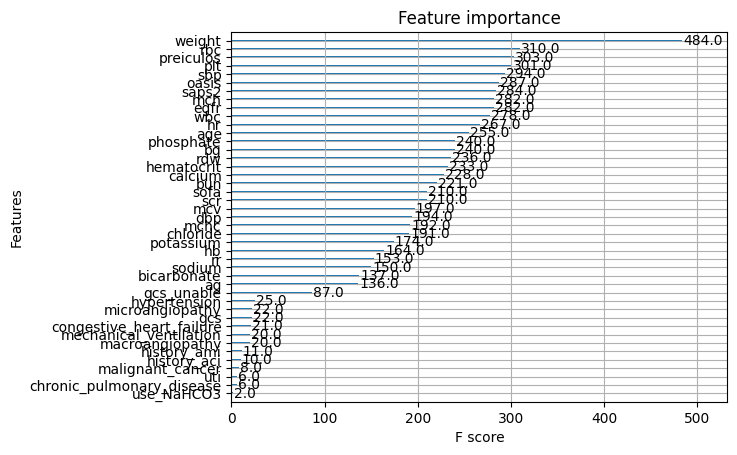

In [16]:
xgb.plot_importance(model)

ImportError: You must install graphviz to plot tree

<Figure size 3000x3000 with 0 Axes>

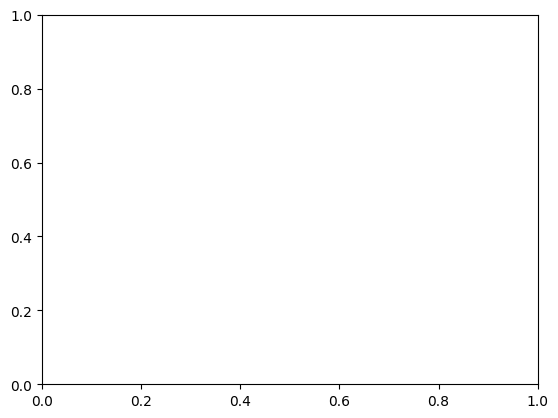

In [17]:
from matplotlib import pyplot as plt


plt.figure(figsize=(30, 30))
xgb.plot_tree(model, num_trees=3)

### Fill missing with knn

In [18]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_val_knn = []
precision_score_list_val_knn = []
recall_score_list_val_knn = []
auc_score_list_val_knn = []
metric_dic_list_val_knn = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeAndFillData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
    y_val = dfVal[labelColumn]  # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_val_knn.append(precision_score(y_test, y_pred))
    recall_score_list_val_knn.append(recall_score(y_test, y_pred))
    auc_score_list_val_knn.append(roc_auc_score(y_test, y_pred_proba))

[0]	validation_0-logloss:0.66600


[1]	validation_0-logloss:0.66296


[2]	validation_0-logloss:0.66105


[3]	validation_0-logloss:0.65869


[4]	validation_0-logloss:0.65604


[5]	validation_0-logloss:0.65411


[6]	validation_0-logloss:0.65283


[7]	validation_0-logloss:0.65008


[8]	validation_0-logloss:0.64761


[9]	validation_0-logloss:0.64588


[10]	validation_0-logloss:0.64341


[11]	validation_0-logloss:0.64126


[12]	validation_0-logloss:0.63951


[13]	validation_0-logloss:0.63780


[14]	validation_0-logloss:0.63596


[15]	validation_0-logloss:0.63393


[16]	validation_0-logloss:0.63171


[17]	validation_0-logloss:0.62957


[18]	validation_0-logloss:0.62861


[19]	validation_0-logloss:0.62686


[20]	validation_0-logloss:0.62493


[21]	validation_0-logloss:0.62300


[22]	validation_0-logloss:0.62117


[23]	validation_0-logloss:0.61964


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:59:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[24]	validation_0-logloss:0.61820


[25]	validation_0-logloss:0.61625


[26]	validation_0-logloss:0.61520


[27]	validation_0-logloss:0.61385


[28]	validation_0-logloss:0.61192


[29]	validation_0-logloss:0.61027


[30]	validation_0-logloss:0.60840


[31]	validation_0-logloss:0.60712


[32]	validation_0-logloss:0.60590


[33]	validation_0-logloss:0.60522


[34]	validation_0-logloss:0.60349


[35]	validation_0-logloss:0.60203


[36]	validation_0-logloss:0.60034


[37]	validation_0-logloss:0.59904


[38]	validation_0-logloss:0.59764


[39]	validation_0-logloss:0.59660


[40]	validation_0-logloss:0.59512


[41]	validation_0-logloss:0.59431


[42]	validation_0-logloss:0.59320


[43]	validation_0-logloss:0.59214


[44]	validation_0-logloss:0.59087


[45]	validation_0-logloss:0.58952


[46]	validation_0-logloss:0.58827


[47]	validation_0-logloss:0.58712


[48]	validation_0-logloss:0.58559


[49]	validation_0-logloss:0.58426


[50]	validation_0-logloss:0.58337


[51]	validation_0-logloss:0.58203


[52]	validation_0-logloss:0.58082


[53]	validation_0-logloss:0.57971


[54]	validation_0-logloss:0.57862


[55]	validation_0-logloss:0.57786


[56]	validation_0-logloss:0.57714


[57]	validation_0-logloss:0.57621

[58]	validation_0-logloss:0.57538


[59]	validation_0-logloss:0.57447


[60]	validation_0-logloss:0.57330


[61]	validation_0-logloss:0.57221


[62]	validation_0-logloss:0.57097


[63]	validation_0-logloss:0.57034


[64]	validation_0-logloss:0.56927


[65]	validation_0-logloss:0.56804


[66]	validation_0-logloss:0.56741


[67]	validation_0-logloss:0.56666


[68]	validation_0-logloss:0.56577


[69]	validation_0-logloss:0.56482


[70]	validation_0-logloss:0.56417


[71]	validation_0-logloss:0.56338


[72]	validation_0-logloss:0.56298


[73]	validation_0-logloss:0.56187


[74]	validation_0-logloss:0.56090


[75]	validation_0-logloss:0.56039


[76]	validation_0-logloss:0.55980


[77]	validation_0-logloss:0.55897


[78]	validation_0-logloss:0.55813


[79]	validation_0-logloss:0.55799


[80]	validation_0-logloss:0.55734


[81]	validation_0-logloss:0.55641


[82]	validation_0-logloss:0.55518


[83]	validation_0-logloss:0.55424


[84]	validation_0-logloss:0.55319


[85]	validation_0-logloss:0.55229


[86]	validation_0-logloss:0.55190


[87]	validation_0-logloss:0.55140


[88]	validation_0-logloss:0.55019


[89]	validation_0-logloss:0.54928


[90]	validation_0-logloss:0.54850


[91]	validation_0-logloss:0.54822


[92]	validation_0-logloss:0.54747


[93]	validation_0-logloss:0.54671


[94]	validation_0-logloss:0.54626


[95]	validation_0-logloss:0.54524


[96]	validation_0-logloss:0.54484


[97]	validation_0-logloss:0.54470


[98]	validation_0-logloss:0.54429


[99]	validation_0-logloss:0.54375


[100]	validation_0-logloss:0.54343


[101]	validation_0-logloss:0.54241


[102]	validation_0-logloss:0.54168


[103]	validation_0-logloss:0.54112


[104]	validation_0-logloss:0.54062


[105]	validation_0-logloss:0.53987


[106]	validation_0-logloss:0.53933


[107]	validation_0-logloss:0.53921


[108]	validation_0-logloss:0.53874


[109]	validation_0-logloss:0.53834


[110]	validation_0-logloss:0.53794


[111]	validation_0-logloss:0.53776

[112]	validation_0-logloss:0.53717


[113]	validation_0-logloss:0.53661


[114]	validation_0-logloss:0.53589


[115]	validation_0-logloss:0.53574


[116]	validation_0-logloss:0.53560

[117]	validation_0-logloss:0.53501


[118]	validation_0-logloss:0.53465


[119]	validation_0-logloss:0.53432


[120]	validation_0-logloss:0.53351


[121]	validation_0-logloss:0.53304


[122]	validation_0-logloss:0.53299


[123]	validation_0-logloss:0.53238


[124]	validation_0-logloss:0.53160


[125]	validation_0-logloss:0.53088


[126]	validation_0-logloss:0.53038


[127]	validation_0-logloss:0.52996


[128]	validation_0-logloss:0.52960

[129]	validation_0-logloss:0.52928


[130]	validation_0-logloss:0.52940


[131]	validation_0-logloss:0.52905


[132]	validation_0-logloss:0.52861


[133]	validation_0-logloss:0.52789


[134]	validation_0-logloss:0.52770


[135]	validation_0-logloss:0.52731


[136]	validation_0-logloss:0.52689


[137]	validation_0-logloss:0.52660


[138]	validation_0-logloss:0.52609


[139]	validation_0-logloss:0.52594


[140]	validation_0-logloss:0.52557


[141]	validation_0-logloss:0.52539


[142]	validation_0-logloss:0.52540


[143]	validation_0-logloss:0.52490


[144]	validation_0-logloss:0.52461


[145]	validation_0-logloss:0.52450


[146]	validation_0-logloss:0.52382


[147]	validation_0-logloss:0.52352


[148]	validation_0-logloss:0.52329


[149]	validation_0-logloss:0.52277


[150]	validation_0-logloss:0.52273


[151]	validation_0-logloss:0.52221


[152]	validation_0-logloss:0.52234


[153]	validation_0-logloss:0.52207


[154]	validation_0-logloss:0.52214


[155]	validation_0-logloss:0.52194


[156]	validation_0-logloss:0.52154


[157]	validation_0-logloss:0.52123


[158]	validation_0-logloss:0.52105


[159]	validation_0-logloss:0.52055


[160]	validation_0-logloss:0.52036


[161]	validation_0-logloss:0.52013


[162]	validation_0-logloss:0.51992


[163]	validation_0-logloss:0.51941


[164]	validation_0-logloss:0.51947


[165]	validation_0-logloss:0.51933


[166]	validation_0-logloss:0.51944


[167]	validation_0-logloss:0.51973


[168]	validation_0-logloss:0.51962


[169]	validation_0-logloss:0.51958


[170]	validation_0-logloss:0.51898


[171]	validation_0-logloss:0.51903


[172]	validation_0-logloss:0.51878


[173]	validation_0-logloss:0.51863


[174]	validation_0-logloss:0.51806


[175]	validation_0-logloss:0.51781


[176]	validation_0-logloss:0.51755


[177]	validation_0-logloss:0.51745


[178]	validation_0-logloss:0.51742


[179]	validation_0-logloss:0.51706


[180]	validation_0-logloss:0.51681


[181]	validation_0-logloss:0.51664


[182]	validation_0-logloss:0.51625


[183]	validation_0-logloss:0.51605


[184]	validation_0-logloss:0.51577


[185]	validation_0-logloss:0.51594


[186]	validation_0-logloss:0.51578


[187]	validation_0-logloss:0.51556


[188]	validation_0-logloss:0.51524


[189]	validation_0-logloss:0.51524


[190]	validation_0-logloss:0.51479


[191]	validation_0-logloss:0.51456


[192]	validation_0-logloss:0.51455


[193]	validation_0-logloss:0.51461


[194]	validation_0-logloss:0.51411


[195]	validation_0-logloss:0.51396


[196]	validation_0-logloss:0.51383


[197]	validation_0-logloss:0.51349


[198]	validation_0-logloss:0.51352


[199]	validation_0-logloss:0.51333


[200]	validation_0-logloss:0.51307


[201]	validation_0-logloss:0.51298


[202]	validation_0-logloss:0.51275

[203]	validation_0-logloss:0.51258


[204]	validation_0-logloss:0.51233


[205]	validation_0-logloss:0.51231


[206]	validation_0-logloss:0.51202


[207]	validation_0-logloss:0.51197


[208]	validation_0-logloss:0.51167


[209]	validation_0-logloss:0.51188


[210]	validation_0-logloss:0.51200


[211]	validation_0-logloss:0.51196


[212]	validation_0-logloss:0.51186


[213]	validation_0-logloss:0.51191


[214]	validation_0-logloss:0.51173


[215]	validation_0-logloss:0.51168


[216]	validation_0-logloss:0.51116


[217]	validation_0-logloss:0.51113


[218]	validation_0-logloss:0.51118


[219]	validation_0-logloss:0.51077


[220]	validation_0-logloss:0.51054

[221]	validation_0-logloss:0.51066


[222]	validation_0-logloss:0.51047


[223]	validation_0-logloss:0.50989


[224]	validation_0-logloss:0.50979


[225]	validation_0-logloss:0.50988


[226]	validation_0-logloss:0.51002

[227]	validation_0-logloss:0.51004


[228]	validation_0-logloss:0.50969


[229]	validation_0-logloss:0.50999


[230]	validation_0-logloss:0.50981


[231]	validation_0-logloss:0.50994


[232]	validation_0-logloss:0.50977


[233]	validation_0-logloss:0.50975


[234]	validation_0-logloss:0.50972


[235]	validation_0-logloss:0.50954


[236]	validation_0-logloss:0.50975


[237]	validation_0-logloss:0.50948


[238]	validation_0-logloss:0.50955


[239]	validation_0-logloss:0.50968


[240]	validation_0-logloss:0.50939


[241]	validation_0-logloss:0.50927


[242]	validation_0-logloss:0.50907


[243]	validation_0-logloss:0.50885


[244]	validation_0-logloss:0.50859


[245]	validation_0-logloss:0.50854


[246]	validation_0-logloss:0.50839


[247]	validation_0-logloss:0.50827


[248]	validation_0-logloss:0.50805


[249]	validation_0-logloss:0.50809


[250]	validation_0-logloss:0.50800


[251]	validation_0-logloss:0.50801


[252]	validation_0-logloss:0.50782


[253]	validation_0-logloss:0.50807


[254]	validation_0-logloss:0.50801


[255]	validation_0-logloss:0.50795


[256]	validation_0-logloss:0.50772


[257]	validation_0-logloss:0.50765


[258]	validation_0-logloss:0.50736


[259]	validation_0-logloss:0.50705


[260]	validation_0-logloss:0.50704


[261]	validation_0-logloss:0.50691


[262]	validation_0-logloss:0.50678


[263]	validation_0-logloss:0.50682


[264]	validation_0-logloss:0.50650


[265]	validation_0-logloss:0.50646


[266]	validation_0-logloss:0.50647


[267]	validation_0-logloss:0.50638


[268]	validation_0-logloss:0.50615


[269]	validation_0-logloss:0.50613


[270]	validation_0-logloss:0.50603


[271]	validation_0-logloss:0.50607


[272]	validation_0-logloss:0.50658


[273]	validation_0-logloss:0.50655


[274]	validation_0-logloss:0.50632


[275]	validation_0-logloss:0.50630


[276]	validation_0-logloss:0.50607


[277]	validation_0-logloss:0.50566


[278]	validation_0-logloss:0.50580


[279]	validation_0-logloss:0.50550


[280]	validation_0-logloss:0.50549

[281]	validation_0-logloss:0.50561


[282]	validation_0-logloss:0.50557


[283]	validation_0-logloss:0.50510


[284]	validation_0-logloss:0.50492


[285]	validation_0-logloss:0.50491


[286]	validation_0-logloss:0.50453


[287]	validation_0-logloss:0.50428


[288]	validation_0-logloss:0.50390


[289]	validation_0-logloss:0.50361


[290]	validation_0-logloss:0.50374


[291]	validation_0-logloss:0.50347


[292]	validation_0-logloss:0.50333


[293]	validation_0-logloss:0.50355


[294]	validation_0-logloss:0.50354


[295]	validation_0-logloss:0.50348


[296]	validation_0-logloss:0.50358


[297]	validation_0-logloss:0.50345


[298]	validation_0-logloss:0.50331


[299]	validation_0-logloss:0.50349


[300]	validation_0-logloss:0.50329


[301]	validation_0-logloss:0.50352


[302]	validation_0-logloss:0.50360


[303]	validation_0-logloss:0.50356


[304]	validation_0-logloss:0.50352


[305]	validation_0-logloss:0.50372


[306]	validation_0-logloss:0.50379


[307]	validation_0-logloss:0.50392


[308]	validation_0-logloss:0.50373


[309]	validation_0-logloss:0.50345


[310]	validation_0-logloss:0.50331


[0]	validation_0-logloss:0.66795


[1]	validation_0-logloss:0.66616


[2]	validation_0-logloss:0.66347


[3]	validation_0-logloss:0.66145


[4]	validation_0-logloss:0.65979


[5]	validation_0-logloss:0.65789


[6]	validation_0-logloss:0.65590


[7]	validation_0-logloss:0.65389


[8]	validation_0-logloss:0.65198


[9]	validation_0-logloss:0.65022


[10]	validation_0-logloss:0.64897


[11]	validation_0-logloss:0.64755


[12]	validation_0-logloss:0.64583


[13]	validation_0-logloss:0.64357


[14]	validation_0-logloss:0.64180


[15]	validation_0-logloss:0.63991


[16]	validation_0-logloss:0.63786


[17]	validation_0-logloss:0.63645


[18]	validation_0-logloss:0.63514


[19]	validation_0-logloss:0.63352


[20]	validation_0-logloss:0.63201


[21]	validation_0-logloss:0.62992


[22]	validation_0-logloss:0.62898


[23]	validation_0-logloss:0.62756


[24]	validation_0-logloss:0.62612


[25]	validation_0-logloss:0.62459


[26]	validation_0-logloss:0.62309


[27]	validation_0-logloss:0.62153


[28]	validation_0-logloss:0.62021


[29]	validation_0-logloss:0.61853


[30]	validation_0-logloss:0.61706


[31]	validation_0-logloss:0.61559


[32]	validation_0-logloss:0.61444


[33]	validation_0-logloss:0.61297


[34]	validation_0-logloss:0.61152


[35]	validation_0-logloss:0.60995


[36]	validation_0-logloss:0.60862


[37]	validation_0-logloss:0.60713


[38]	validation_0-logloss:0.60565


[39]	validation_0-logloss:0.60444


[40]	validation_0-logloss:0.60331


[41]	validation_0-logloss:0.60194


[42]	validation_0-logloss:0.60058


[43]	validation_0-logloss:0.59951


[44]	validation_0-logloss:0.59830


[45]	validation_0-logloss:0.59729


[46]	validation_0-logloss:0.59625


[47]	validation_0-logloss:0.59511


[48]	validation_0-logloss:0.59466


[49]	validation_0-logloss:0.59407


[50]	validation_0-logloss:0.59248


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:59:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[51]	validation_0-logloss:0.59133


[52]	validation_0-logloss:0.59025


[53]	validation_0-logloss:0.58968


[54]	validation_0-logloss:0.58848


[55]	validation_0-logloss:0.58778


[56]	validation_0-logloss:0.58716


[57]	validation_0-logloss:0.58584


[58]	validation_0-logloss:0.58461


[59]	validation_0-logloss:0.58425


[60]	validation_0-logloss:0.58327


[61]	validation_0-logloss:0.58251


[62]	validation_0-logloss:0.58157


[63]	validation_0-logloss:0.58054


[64]	validation_0-logloss:0.57977


[65]	validation_0-logloss:0.57905


[66]	validation_0-logloss:0.57795


[67]	validation_0-logloss:0.57729


[68]	validation_0-logloss:0.57657


[69]	validation_0-logloss:0.57594


[70]	validation_0-logloss:0.57500


[71]	validation_0-logloss:0.57425


[72]	validation_0-logloss:0.57292


[73]	validation_0-logloss:0.57213


[74]	validation_0-logloss:0.57150


[75]	validation_0-logloss:0.57066


[76]	validation_0-logloss:0.57004


[77]	validation_0-logloss:0.56939


[78]	validation_0-logloss:0.56825


[79]	validation_0-logloss:0.56786


[80]	validation_0-logloss:0.56733


[81]	validation_0-logloss:0.56619


[82]	validation_0-logloss:0.56570


[83]	validation_0-logloss:0.56451

[84]	validation_0-logloss:0.56335


[85]	validation_0-logloss:0.56308


[86]	validation_0-logloss:0.56248


[87]	validation_0-logloss:0.56178


[88]	validation_0-logloss:0.56110


[89]	validation_0-logloss:0.56058


[90]	validation_0-logloss:0.55991


[91]	validation_0-logloss:0.55954


[92]	validation_0-logloss:0.55957


[93]	validation_0-logloss:0.55919


[94]	validation_0-logloss:0.55849


[95]	validation_0-logloss:0.55795


[96]	validation_0-logloss:0.55750


[97]	validation_0-logloss:0.55703


[98]	validation_0-logloss:0.55666


[99]	validation_0-logloss:0.55599

[100]	validation_0-logloss:0.55594


[101]	validation_0-logloss:0.55478


[102]	validation_0-logloss:0.55406


[103]	validation_0-logloss:0.55327


[104]	validation_0-logloss:0.55266


[105]	validation_0-logloss:0.55210


[106]	validation_0-logloss:0.55144


[107]	validation_0-logloss:0.55150


[108]	validation_0-logloss:0.55125


[109]	validation_0-logloss:0.55048


[110]	validation_0-logloss:0.55024


[111]	validation_0-logloss:0.54982


[112]	validation_0-logloss:0.54914


[113]	validation_0-logloss:0.54897


[114]	validation_0-logloss:0.54830

[115]	validation_0-logloss:0.54788


[116]	validation_0-logloss:0.54745


[117]	validation_0-logloss:0.54691


[118]	validation_0-logloss:0.54645


[119]	validation_0-logloss:0.54593


[120]	validation_0-logloss:0.54539

[121]	validation_0-logloss:0.54490


[122]	validation_0-logloss:0.54480


[123]	validation_0-logloss:0.54436


[124]	validation_0-logloss:0.54402


[125]	validation_0-logloss:0.54350


[126]	validation_0-logloss:0.54303


[127]	validation_0-logloss:0.54288


[128]	validation_0-logloss:0.54258


[129]	validation_0-logloss:0.54200


[130]	validation_0-logloss:0.54168


[131]	validation_0-logloss:0.54134


[132]	validation_0-logloss:0.54111


[133]	validation_0-logloss:0.54038


[134]	validation_0-logloss:0.53969


[135]	validation_0-logloss:0.53929


[136]	validation_0-logloss:0.53905


[137]	validation_0-logloss:0.53901


[138]	validation_0-logloss:0.53880


[139]	validation_0-logloss:0.53818


[140]	validation_0-logloss:0.53818


[141]	validation_0-logloss:0.53801

[142]	validation_0-logloss:0.53780


[143]	validation_0-logloss:0.53763


[144]	validation_0-logloss:0.53734


[145]	validation_0-logloss:0.53743


[146]	validation_0-logloss:0.53709


[147]	validation_0-logloss:0.53645


[148]	validation_0-logloss:0.53615


[149]	validation_0-logloss:0.53568

[150]	validation_0-logloss:0.53586


[151]	validation_0-logloss:0.53569

[152]	validation_0-logloss:0.53574


[153]	validation_0-logloss:0.53535


[154]	validation_0-logloss:0.53530


[155]	validation_0-logloss:0.53532


[156]	validation_0-logloss:0.53510


[157]	validation_0-logloss:0.53496


[158]	validation_0-logloss:0.53500


[159]	validation_0-logloss:0.53505


[160]	validation_0-logloss:0.53475


[161]	validation_0-logloss:0.53427


[162]	validation_0-logloss:0.53388


[163]	validation_0-logloss:0.53340


[164]	validation_0-logloss:0.53307


[165]	validation_0-logloss:0.53289


[166]	validation_0-logloss:0.53260


[167]	validation_0-logloss:0.53249


[168]	validation_0-logloss:0.53268


[169]	validation_0-logloss:0.53227


[170]	validation_0-logloss:0.53241


[171]	validation_0-logloss:0.53232


[172]	validation_0-logloss:0.53160


[173]	validation_0-logloss:0.53112


[174]	validation_0-logloss:0.53090


[175]	validation_0-logloss:0.53083


[176]	validation_0-logloss:0.53081


[177]	validation_0-logloss:0.53085


[178]	validation_0-logloss:0.53061

[179]	validation_0-logloss:0.53054


[180]	validation_0-logloss:0.53039

[181]	validation_0-logloss:0.53011

[182]	validation_0-logloss:0.53019


[183]	validation_0-logloss:0.52985


[184]	validation_0-logloss:0.53007


[185]	validation_0-logloss:0.53022


[186]	validation_0-logloss:0.53020


[187]	validation_0-logloss:0.53017


[188]	validation_0-logloss:0.52973

[189]	validation_0-logloss:0.52954


[190]	validation_0-logloss:0.52921


[191]	validation_0-logloss:0.52911

[192]	validation_0-logloss:0.52904


[193]	validation_0-logloss:0.52844


[194]	validation_0-logloss:0.52857

[195]	validation_0-logloss:0.52861


[196]	validation_0-logloss:0.52884


[197]	validation_0-logloss:0.52886


[198]	validation_0-logloss:0.52895


[199]	validation_0-logloss:0.52877


[200]	validation_0-logloss:0.52880


[201]	validation_0-logloss:0.52856


[202]	validation_0-logloss:0.52854


[0]	validation_0-logloss:0.66814


[1]	validation_0-logloss:0.66590


[2]	validation_0-logloss:0.66451


[3]	validation_0-logloss:0.66273


[4]	validation_0-logloss:0.66089


[5]	validation_0-logloss:0.65951


[6]	validation_0-logloss:0.65794


[7]	validation_0-logloss:0.65651


[8]	validation_0-logloss:0.65498


[9]	validation_0-logloss:0.65284


[10]	validation_0-logloss:0.65151


[11]	validation_0-logloss:0.64971


[12]	validation_0-logloss:0.64874


[13]	validation_0-logloss:0.64748


[14]	validation_0-logloss:0.64549


[15]	validation_0-logloss:0.64402


[16]	validation_0-logloss:0.64293


[17]	validation_0-logloss:0.64156


[18]	validation_0-logloss:0.64054


[19]	validation_0-logloss:0.63927


[20]	validation_0-logloss:0.63764


[21]	validation_0-logloss:0.63587


[22]	validation_0-logloss:0.63513


[23]	validation_0-logloss:0.63353


[24]	validation_0-logloss:0.63262


[25]	validation_0-logloss:0.63166


[26]	validation_0-logloss:0.63111


[27]	validation_0-logloss:0.62997


[28]	validation_0-logloss:0.62887


[29]	validation_0-logloss:0.62792


[30]	validation_0-logloss:0.62657


[31]	validation_0-logloss:0.62569


[32]	validation_0-logloss:0.62489


[33]	validation_0-logloss:0.62380


[34]	validation_0-logloss:0.62375


[35]	validation_0-logloss:0.62291


[36]	validation_0-logloss:0.62123


[37]	validation_0-logloss:0.62105


[38]	validation_0-logloss:0.62034


[39]	validation_0-logloss:0.61946


[40]	validation_0-logloss:0.61861


[41]	validation_0-logloss:0.61755


[42]	validation_0-logloss:0.61644


[43]	validation_0-logloss:0.61546


[44]	validation_0-logloss:0.61463


[45]	validation_0-logloss:0.61330


[46]	validation_0-logloss:0.61272


[47]	validation_0-logloss:0.61121


[48]	validation_0-logloss:0.61054


[49]	validation_0-logloss:0.60963


[50]	validation_0-logloss:0.60908


[51]	validation_0-logloss:0.60818


[52]	validation_0-logloss:0.60746


[53]	validation_0-logloss:0.60663


[54]	validation_0-logloss:0.60582


[55]	validation_0-logloss:0.60462


[56]	validation_0-logloss:0.60349


[57]	validation_0-logloss:0.60266


[58]	validation_0-logloss:0.60203


[59]	validation_0-logloss:0.60128


[60]	validation_0-logloss:0.60065


[61]	validation_0-logloss:0.60020


[62]	validation_0-logloss:0.60012


[63]	validation_0-logloss:0.59902


[64]	validation_0-logloss:0.59857


[65]	validation_0-logloss:0.59833


[66]	validation_0-logloss:0.59738


[67]	validation_0-logloss:0.59693


[68]	validation_0-logloss:0.59633


[69]	validation_0-logloss:0.59558


[70]	validation_0-logloss:0.59475


[71]	validation_0-logloss:0.59442


[72]	validation_0-logloss:0.59401


[73]	validation_0-logloss:0.59368


[74]	validation_0-logloss:0.59273


[75]	validation_0-logloss:0.59196


[76]	validation_0-logloss:0.59149


[77]	validation_0-logloss:0.59069


[78]	validation_0-logloss:0.59009


[79]	validation_0-logloss:0.58943


[80]	validation_0-logloss:0.58864


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:59:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[81]	validation_0-logloss:0.58842


[82]	validation_0-logloss:0.58794


[83]	validation_0-logloss:0.58746


[84]	validation_0-logloss:0.58694


[85]	validation_0-logloss:0.58685


[86]	validation_0-logloss:0.58574


[87]	validation_0-logloss:0.58527


[88]	validation_0-logloss:0.58457


[89]	validation_0-logloss:0.58425


[90]	validation_0-logloss:0.58364


[91]	validation_0-logloss:0.58327


[92]	validation_0-logloss:0.58258


[93]	validation_0-logloss:0.58224


[94]	validation_0-logloss:0.58187


[95]	validation_0-logloss:0.58117


[96]	validation_0-logloss:0.58092


[97]	validation_0-logloss:0.58046


[98]	validation_0-logloss:0.57988


[99]	validation_0-logloss:0.57958


[100]	validation_0-logloss:0.57883


[101]	validation_0-logloss:0.57875


[102]	validation_0-logloss:0.57843


[103]	validation_0-logloss:0.57803


[104]	validation_0-logloss:0.57759

[105]	validation_0-logloss:0.57735


[106]	validation_0-logloss:0.57723


[107]	validation_0-logloss:0.57702


[108]	validation_0-logloss:0.57659


[109]	validation_0-logloss:0.57631


[110]	validation_0-logloss:0.57586


[111]	validation_0-logloss:0.57583


[112]	validation_0-logloss:0.57565


[113]	validation_0-logloss:0.57509


[114]	validation_0-logloss:0.57484


[115]	validation_0-logloss:0.57468


[116]	validation_0-logloss:0.57438


[117]	validation_0-logloss:0.57399


[118]	validation_0-logloss:0.57354


[119]	validation_0-logloss:0.57320


[120]	validation_0-logloss:0.57300


[121]	validation_0-logloss:0.57229


[122]	validation_0-logloss:0.57200


[123]	validation_0-logloss:0.57146


[124]	validation_0-logloss:0.57145


[125]	validation_0-logloss:0.57115


[126]	validation_0-logloss:0.57095


[127]	validation_0-logloss:0.57060


[128]	validation_0-logloss:0.56959


[129]	validation_0-logloss:0.56909


[130]	validation_0-logloss:0.56922


[131]	validation_0-logloss:0.56947


[132]	validation_0-logloss:0.56911


[133]	validation_0-logloss:0.56888


[134]	validation_0-logloss:0.56855


[135]	validation_0-logloss:0.56827


[136]	validation_0-logloss:0.56790


[137]	validation_0-logloss:0.56807


[138]	validation_0-logloss:0.56798


[139]	validation_0-logloss:0.56768


[140]	validation_0-logloss:0.56751


[141]	validation_0-logloss:0.56749


[142]	validation_0-logloss:0.56733


[143]	validation_0-logloss:0.56713


[144]	validation_0-logloss:0.56681


[145]	validation_0-logloss:0.56639


[146]	validation_0-logloss:0.56592


[147]	validation_0-logloss:0.56539


[148]	validation_0-logloss:0.56498


[149]	validation_0-logloss:0.56491


[150]	validation_0-logloss:0.56482


[151]	validation_0-logloss:0.56480


[152]	validation_0-logloss:0.56418


[153]	validation_0-logloss:0.56426


[154]	validation_0-logloss:0.56412


[155]	validation_0-logloss:0.56354


[156]	validation_0-logloss:0.56335


[157]	validation_0-logloss:0.56336


[158]	validation_0-logloss:0.56337


[159]	validation_0-logloss:0.56340


[160]	validation_0-logloss:0.56345


[161]	validation_0-logloss:0.56397


[162]	validation_0-logloss:0.56382


[163]	validation_0-logloss:0.56369


[164]	validation_0-logloss:0.56330


[165]	validation_0-logloss:0.56347


[166]	validation_0-logloss:0.56337


[167]	validation_0-logloss:0.56361


[168]	validation_0-logloss:0.56377


[169]	validation_0-logloss:0.56363


[170]	validation_0-logloss:0.56367

[171]	validation_0-logloss:0.56351


[172]	validation_0-logloss:0.56340


[173]	validation_0-logloss:0.56334


[174]	validation_0-logloss:0.56327


[175]	validation_0-logloss:0.56293


[176]	validation_0-logloss:0.56288


[177]	validation_0-logloss:0.56257


[178]	validation_0-logloss:0.56261


[179]	validation_0-logloss:0.56259


[180]	validation_0-logloss:0.56261


[181]	validation_0-logloss:0.56263


[182]	validation_0-logloss:0.56225


[183]	validation_0-logloss:0.56201


[184]	validation_0-logloss:0.56184


[185]	validation_0-logloss:0.56184


[186]	validation_0-logloss:0.56164


[187]	validation_0-logloss:0.56141


[188]	validation_0-logloss:0.56133


[189]	validation_0-logloss:0.56119


[190]	validation_0-logloss:0.56063


[191]	validation_0-logloss:0.56081


[192]	validation_0-logloss:0.56044


[193]	validation_0-logloss:0.56003


[194]	validation_0-logloss:0.55955


[195]	validation_0-logloss:0.55932


[196]	validation_0-logloss:0.55907

[197]	validation_0-logloss:0.55896


[198]	validation_0-logloss:0.55891


[199]	validation_0-logloss:0.55926


[200]	validation_0-logloss:0.55911


[201]	validation_0-logloss:0.55924


[202]	validation_0-logloss:0.55926


[203]	validation_0-logloss:0.55933


[204]	validation_0-logloss:0.55927


[205]	validation_0-logloss:0.55919


[206]	validation_0-logloss:0.55903


[207]	validation_0-logloss:0.55915


[208]	validation_0-logloss:0.55941


[0]	validation_0-logloss:0.66788


[1]	validation_0-logloss:0.66625


[2]	validation_0-logloss:0.66419


[3]	validation_0-logloss:0.66255


[4]	validation_0-logloss:0.66035


[5]	validation_0-logloss:0.65808


[6]	validation_0-logloss:0.65685


[7]	validation_0-logloss:0.65496


[8]	validation_0-logloss:0.65364


[9]	validation_0-logloss:0.65200


[10]	validation_0-logloss:0.65059


[11]	validation_0-logloss:0.64875


[12]	validation_0-logloss:0.64736


[13]	validation_0-logloss:0.64588


[14]	validation_0-logloss:0.64404


[15]	validation_0-logloss:0.64223


[16]	validation_0-logloss:0.64032


[17]	validation_0-logloss:0.63923


[18]	validation_0-logloss:0.63808


[19]	validation_0-logloss:0.63700


[20]	validation_0-logloss:0.63534


[21]	validation_0-logloss:0.63408


[22]	validation_0-logloss:0.63300


[23]	validation_0-logloss:0.63145


[24]	validation_0-logloss:0.62995


[25]	validation_0-logloss:0.62819


[26]	validation_0-logloss:0.62691


[27]	validation_0-logloss:0.62525


[28]	validation_0-logloss:0.62369


[29]	validation_0-logloss:0.62264


[30]	validation_0-logloss:0.62165


[31]	validation_0-logloss:0.62093


[32]	validation_0-logloss:0.61972


[33]	validation_0-logloss:0.61895


[34]	validation_0-logloss:0.61793


[35]	validation_0-logloss:0.61669


[36]	validation_0-logloss:0.61557


[37]	validation_0-logloss:0.61433


[38]	validation_0-logloss:0.61314


[39]	validation_0-logloss:0.61210


[40]	validation_0-logloss:0.61081


[41]	validation_0-logloss:0.60998


[42]	validation_0-logloss:0.60917


[43]	validation_0-logloss:0.60831


[44]	validation_0-logloss:0.60737


[45]	validation_0-logloss:0.60604


[46]	validation_0-logloss:0.60482


[47]	validation_0-logloss:0.60343


[48]	validation_0-logloss:0.60231


[49]	validation_0-logloss:0.60133


[50]	validation_0-logloss:0.60040


[51]	validation_0-logloss:0.59957


[52]	validation_0-logloss:0.59868


[53]	validation_0-logloss:0.59794


[54]	validation_0-logloss:0.59718


[55]	validation_0-logloss:0.59642


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:00:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[56]	validation_0-logloss:0.59564


[57]	validation_0-logloss:0.59474


[58]	validation_0-logloss:0.59364


[59]	validation_0-logloss:0.59274


[60]	validation_0-logloss:0.59174


[61]	validation_0-logloss:0.59089


[62]	validation_0-logloss:0.58967


[63]	validation_0-logloss:0.58853


[64]	validation_0-logloss:0.58747


[65]	validation_0-logloss:0.58652


[66]	validation_0-logloss:0.58636


[67]	validation_0-logloss:0.58647


[68]	validation_0-logloss:0.58552


[69]	validation_0-logloss:0.58459


[70]	validation_0-logloss:0.58406


[71]	validation_0-logloss:0.58335


[72]	validation_0-logloss:0.58304


[73]	validation_0-logloss:0.58248


[74]	validation_0-logloss:0.58192

[75]	validation_0-logloss:0.58123

[76]	validation_0-logloss:0.58075


[77]	validation_0-logloss:0.58044


[78]	validation_0-logloss:0.57973


[79]	validation_0-logloss:0.57914


[80]	validation_0-logloss:0.57870


[81]	validation_0-logloss:0.57819


[82]	validation_0-logloss:0.57763


[83]	validation_0-logloss:0.57685


[84]	validation_0-logloss:0.57617


[85]	validation_0-logloss:0.57529


[86]	validation_0-logloss:0.57476


[87]	validation_0-logloss:0.57419


[88]	validation_0-logloss:0.57298


[89]	validation_0-logloss:0.57239


[90]	validation_0-logloss:0.57231


[91]	validation_0-logloss:0.57201


[92]	validation_0-logloss:0.57191


[93]	validation_0-logloss:0.57109


[94]	validation_0-logloss:0.57095


[95]	validation_0-logloss:0.57082


[96]	validation_0-logloss:0.57039


[97]	validation_0-logloss:0.56981


[98]	validation_0-logloss:0.56958


[99]	validation_0-logloss:0.56919


[100]	validation_0-logloss:0.56899


[101]	validation_0-logloss:0.56869


[102]	validation_0-logloss:0.56824


[103]	validation_0-logloss:0.56797

[104]	validation_0-logloss:0.56734


[105]	validation_0-logloss:0.56697

[106]	validation_0-logloss:0.56639


[107]	validation_0-logloss:0.56571


[108]	validation_0-logloss:0.56502


[109]	validation_0-logloss:0.56464


[110]	validation_0-logloss:0.56458

[111]	validation_0-logloss:0.56410


[112]	validation_0-logloss:0.56386

[113]	validation_0-logloss:0.56364


[114]	validation_0-logloss:0.56312


[115]	validation_0-logloss:0.56284


[116]	validation_0-logloss:0.56275


[117]	validation_0-logloss:0.56216


[118]	validation_0-logloss:0.56153


[119]	validation_0-logloss:0.56136


[120]	validation_0-logloss:0.56100


[121]	validation_0-logloss:0.56079


[122]	validation_0-logloss:0.56074


[123]	validation_0-logloss:0.56025


[124]	validation_0-logloss:0.56007

[125]	validation_0-logloss:0.55984


[126]	validation_0-logloss:0.55920


[127]	validation_0-logloss:0.55884


[128]	validation_0-logloss:0.55864


[129]	validation_0-logloss:0.55805


[130]	validation_0-logloss:0.55786


[131]	validation_0-logloss:0.55736


[132]	validation_0-logloss:0.55729


[133]	validation_0-logloss:0.55710


[134]	validation_0-logloss:0.55692


[135]	validation_0-logloss:0.55649


[136]	validation_0-logloss:0.55618


[137]	validation_0-logloss:0.55600


[138]	validation_0-logloss:0.55608


[139]	validation_0-logloss:0.55584


[140]	validation_0-logloss:0.55540


[141]	validation_0-logloss:0.55516


[142]	validation_0-logloss:0.55464


[143]	validation_0-logloss:0.55447


[144]	validation_0-logloss:0.55449


[145]	validation_0-logloss:0.55429


[146]	validation_0-logloss:0.55412


[147]	validation_0-logloss:0.55395


[148]	validation_0-logloss:0.55337


[149]	validation_0-logloss:0.55318


[150]	validation_0-logloss:0.55320


[151]	validation_0-logloss:0.55268


[152]	validation_0-logloss:0.55262


[153]	validation_0-logloss:0.55224


[154]	validation_0-logloss:0.55222


[155]	validation_0-logloss:0.55239


[156]	validation_0-logloss:0.55226


[157]	validation_0-logloss:0.55208


[158]	validation_0-logloss:0.55162


[159]	validation_0-logloss:0.55126


[160]	validation_0-logloss:0.55039


[161]	validation_0-logloss:0.55017


[162]	validation_0-logloss:0.54969


[163]	validation_0-logloss:0.54924


[164]	validation_0-logloss:0.54861


[165]	validation_0-logloss:0.54840


[166]	validation_0-logloss:0.54815


[167]	validation_0-logloss:0.54822


[168]	validation_0-logloss:0.54827


[169]	validation_0-logloss:0.54811

[170]	validation_0-logloss:0.54807


[171]	validation_0-logloss:0.54801


[172]	validation_0-logloss:0.54803


[173]	validation_0-logloss:0.54773


[174]	validation_0-logloss:0.54782


[175]	validation_0-logloss:0.54755


[176]	validation_0-logloss:0.54758


[177]	validation_0-logloss:0.54725


[178]	validation_0-logloss:0.54705


[179]	validation_0-logloss:0.54716


[180]	validation_0-logloss:0.54697


[181]	validation_0-logloss:0.54680


[182]	validation_0-logloss:0.54688


[183]	validation_0-logloss:0.54663


[184]	validation_0-logloss:0.54637


[185]	validation_0-logloss:0.54617


[186]	validation_0-logloss:0.54617


[187]	validation_0-logloss:0.54640


[188]	validation_0-logloss:0.54620


[189]	validation_0-logloss:0.54580


[190]	validation_0-logloss:0.54592


[191]	validation_0-logloss:0.54584


[192]	validation_0-logloss:0.54581


[193]	validation_0-logloss:0.54565


[194]	validation_0-logloss:0.54563


[195]	validation_0-logloss:0.54547


[196]	validation_0-logloss:0.54550


[197]	validation_0-logloss:0.54528


[198]	validation_0-logloss:0.54528


[199]	validation_0-logloss:0.54584


[200]	validation_0-logloss:0.54597


[201]	validation_0-logloss:0.54607


[202]	validation_0-logloss:0.54563


[203]	validation_0-logloss:0.54553


[204]	validation_0-logloss:0.54585


[205]	validation_0-logloss:0.54621


[206]	validation_0-logloss:0.54596


[0]	validation_0-logloss:0.66802


[1]	validation_0-logloss:0.66609


[2]	validation_0-logloss:0.66439


[3]	validation_0-logloss:0.66245


[4]	validation_0-logloss:0.66073


[5]	validation_0-logloss:0.65935


[6]	validation_0-logloss:0.65764


[7]	validation_0-logloss:0.65565


[8]	validation_0-logloss:0.65395


[9]	validation_0-logloss:0.65245


[10]	validation_0-logloss:0.65092


[11]	validation_0-logloss:0.64963


[12]	validation_0-logloss:0.64785


[13]	validation_0-logloss:0.64600


[14]	validation_0-logloss:0.64440


[15]	validation_0-logloss:0.64285


[16]	validation_0-logloss:0.64092


[17]	validation_0-logloss:0.63923


[18]	validation_0-logloss:0.63777


[19]	validation_0-logloss:0.63663


[20]	validation_0-logloss:0.63545


[21]	validation_0-logloss:0.63403


[22]	validation_0-logloss:0.63220


[23]	validation_0-logloss:0.63040


[24]	validation_0-logloss:0.62900


[25]	validation_0-logloss:0.62783


[26]	validation_0-logloss:0.62698


[27]	validation_0-logloss:0.62544


[28]	validation_0-logloss:0.62406


[29]	validation_0-logloss:0.62263


[30]	validation_0-logloss:0.62134


[31]	validation_0-logloss:0.61985


[32]	validation_0-logloss:0.61856


[33]	validation_0-logloss:0.61758


[34]	validation_0-logloss:0.61594


[35]	validation_0-logloss:0.61515


[36]	validation_0-logloss:0.61428


[37]	validation_0-logloss:0.61299


[38]	validation_0-logloss:0.61225


[39]	validation_0-logloss:0.61113


[40]	validation_0-logloss:0.61012


[41]	validation_0-logloss:0.60937


[42]	validation_0-logloss:0.60801


[43]	validation_0-logloss:0.60742


[44]	validation_0-logloss:0.60669


[45]	validation_0-logloss:0.60573


[46]	validation_0-logloss:0.60481


[47]	validation_0-logloss:0.60398


[48]	validation_0-logloss:0.60293


[49]	validation_0-logloss:0.60167


[50]	validation_0-logloss:0.60119


[51]	validation_0-logloss:0.60051


[52]	validation_0-logloss:0.60003


[53]	validation_0-logloss:0.59992


[54]	validation_0-logloss:0.59928


[55]	validation_0-logloss:0.59840


[56]	validation_0-logloss:0.59730


[57]	validation_0-logloss:0.59585


[58]	validation_0-logloss:0.59527


[59]	validation_0-logloss:0.59456


[60]	validation_0-logloss:0.59344


[61]	validation_0-logloss:0.59285


[62]	validation_0-logloss:0.59165


[63]	validation_0-logloss:0.59070


[64]	validation_0-logloss:0.58991


[65]	validation_0-logloss:0.58893


[66]	validation_0-logloss:0.58836


[67]	validation_0-logloss:0.58816


[68]	validation_0-logloss:0.58752


[69]	validation_0-logloss:0.58692


[70]	validation_0-logloss:0.58654


[71]	validation_0-logloss:0.58611


[72]	validation_0-logloss:0.58525


[73]	validation_0-logloss:0.58497


[74]	validation_0-logloss:0.58446


[75]	validation_0-logloss:0.58391


[76]	validation_0-logloss:0.58356


[77]	validation_0-logloss:0.58329


[78]	validation_0-logloss:0.58285


[79]	validation_0-logloss:0.58210


[80]	validation_0-logloss:0.58152


[81]	validation_0-logloss:0.58125


[82]	validation_0-logloss:0.58093


[83]	validation_0-logloss:0.58037


[84]	validation_0-logloss:0.58009


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:00:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[85]	validation_0-logloss:0.57982


[86]	validation_0-logloss:0.57960


[87]	validation_0-logloss:0.57938


[88]	validation_0-logloss:0.57888


[89]	validation_0-logloss:0.57820


[90]	validation_0-logloss:0.57780


[91]	validation_0-logloss:0.57707


[92]	validation_0-logloss:0.57641


[93]	validation_0-logloss:0.57590


[94]	validation_0-logloss:0.57530


[95]	validation_0-logloss:0.57463


[96]	validation_0-logloss:0.57404


[97]	validation_0-logloss:0.57342


[98]	validation_0-logloss:0.57323


[99]	validation_0-logloss:0.57290


[100]	validation_0-logloss:0.57236


[101]	validation_0-logloss:0.57181


[102]	validation_0-logloss:0.57126


[103]	validation_0-logloss:0.57098


[104]	validation_0-logloss:0.57055


[105]	validation_0-logloss:0.57055


[106]	validation_0-logloss:0.57045


[107]	validation_0-logloss:0.56997


[108]	validation_0-logloss:0.56928


[109]	validation_0-logloss:0.56898


[110]	validation_0-logloss:0.56850


[111]	validation_0-logloss:0.56790


[112]	validation_0-logloss:0.56765

[113]	validation_0-logloss:0.56738


[114]	validation_0-logloss:0.56695


[115]	validation_0-logloss:0.56670


[116]	validation_0-logloss:0.56614


[117]	validation_0-logloss:0.56581

[118]	validation_0-logloss:0.56553

[119]	validation_0-logloss:0.56511


[120]	validation_0-logloss:0.56525


[121]	validation_0-logloss:0.56497

[122]	validation_0-logloss:0.56488

[123]	validation_0-logloss:0.56480


[124]	validation_0-logloss:0.56425


[125]	validation_0-logloss:0.56403


[126]	validation_0-logloss:0.56383


[127]	validation_0-logloss:0.56381


[128]	validation_0-logloss:0.56356


[129]	validation_0-logloss:0.56397


[130]	validation_0-logloss:0.56358


[131]	validation_0-logloss:0.56370


[132]	validation_0-logloss:0.56354


[133]	validation_0-logloss:0.56344


[134]	validation_0-logloss:0.56327


[135]	validation_0-logloss:0.56288


[136]	validation_0-logloss:0.56224

[137]	validation_0-logloss:0.56210


[138]	validation_0-logloss:0.56223


[139]	validation_0-logloss:0.56177


[140]	validation_0-logloss:0.56186


[141]	validation_0-logloss:0.56132


[142]	validation_0-logloss:0.56111


[143]	validation_0-logloss:0.56076


[144]	validation_0-logloss:0.56057


[145]	validation_0-logloss:0.56002


[146]	validation_0-logloss:0.55927


[147]	validation_0-logloss:0.55895


[148]	validation_0-logloss:0.55897


[149]	validation_0-logloss:0.55864


[150]	validation_0-logloss:0.55837


[151]	validation_0-logloss:0.55783


[152]	validation_0-logloss:0.55764

[153]	validation_0-logloss:0.55715


[154]	validation_0-logloss:0.55721


[155]	validation_0-logloss:0.55700


[156]	validation_0-logloss:0.55666


[157]	validation_0-logloss:0.55690


[158]	validation_0-logloss:0.55723


[159]	validation_0-logloss:0.55701


[160]	validation_0-logloss:0.55692


[161]	validation_0-logloss:0.55676


[162]	validation_0-logloss:0.55638


[163]	validation_0-logloss:0.55632


[164]	validation_0-logloss:0.55650


[165]	validation_0-logloss:0.55652


[166]	validation_0-logloss:0.55631


[167]	validation_0-logloss:0.55623

[168]	validation_0-logloss:0.55616


[169]	validation_0-logloss:0.55620


[170]	validation_0-logloss:0.55626


[171]	validation_0-logloss:0.55599


[172]	validation_0-logloss:0.55593

[173]	validation_0-logloss:0.55590


[174]	validation_0-logloss:0.55599


[175]	validation_0-logloss:0.55555


[176]	validation_0-logloss:0.55572


[177]	validation_0-logloss:0.55585


[178]	validation_0-logloss:0.55603


[179]	validation_0-logloss:0.55558


[180]	validation_0-logloss:0.55525


[181]	validation_0-logloss:0.55497


[182]	validation_0-logloss:0.55490


[183]	validation_0-logloss:0.55519


[184]	validation_0-logloss:0.55513


[185]	validation_0-logloss:0.55506


[186]	validation_0-logloss:0.55527


[187]	validation_0-logloss:0.55515


[188]	validation_0-logloss:0.55523


[189]	validation_0-logloss:0.55507


[190]	validation_0-logloss:0.55535


[191]	validation_0-logloss:0.55521


In [19]:
print(f"Average AUC: {np.mean(auc_score_list_val_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_val_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_val_knn)}")

Average AUC: 0.7844984510240918
Average Accuracy: 0.7263708377627653
Average Precision: 0.6845898348020589
Average Recall: 0.5760134378499441
